<a href="https://colab.research.google.com/github/Dovermore/COMP5046-ass1/blob/master/zhua9812_COMP5046_Ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style*

1. Codes are all done using objected oriented style, and preprocessings are all packed inside functions. Demo test run of preprocessing are provided for each section, but not on the full data
2. To load models arrange the files in the following way
    - root_path
        - word (directory)
            - zhua9812_word.pt (file)
        - character (directory)
            - zhua9812_character.pt (file)
        - sequence (directory)
            - zhua9812_sequence.pt (file)
3. To load models, run the cell with in sections with load model

In [ ]:
# Run this cell BEFORE executing all the object oriented sections

# Input your base directory
from pathlib import Path
root_path = Path(".")

## Please run EVERY cell in the object oriented section first

# 1 - Data Preprocessing

## 1.1. Download Dataset

In [ ]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


## 1.2. Preprocess data

*You are required to describe which data preprocessing techniques were conducted with justification of your decision. *

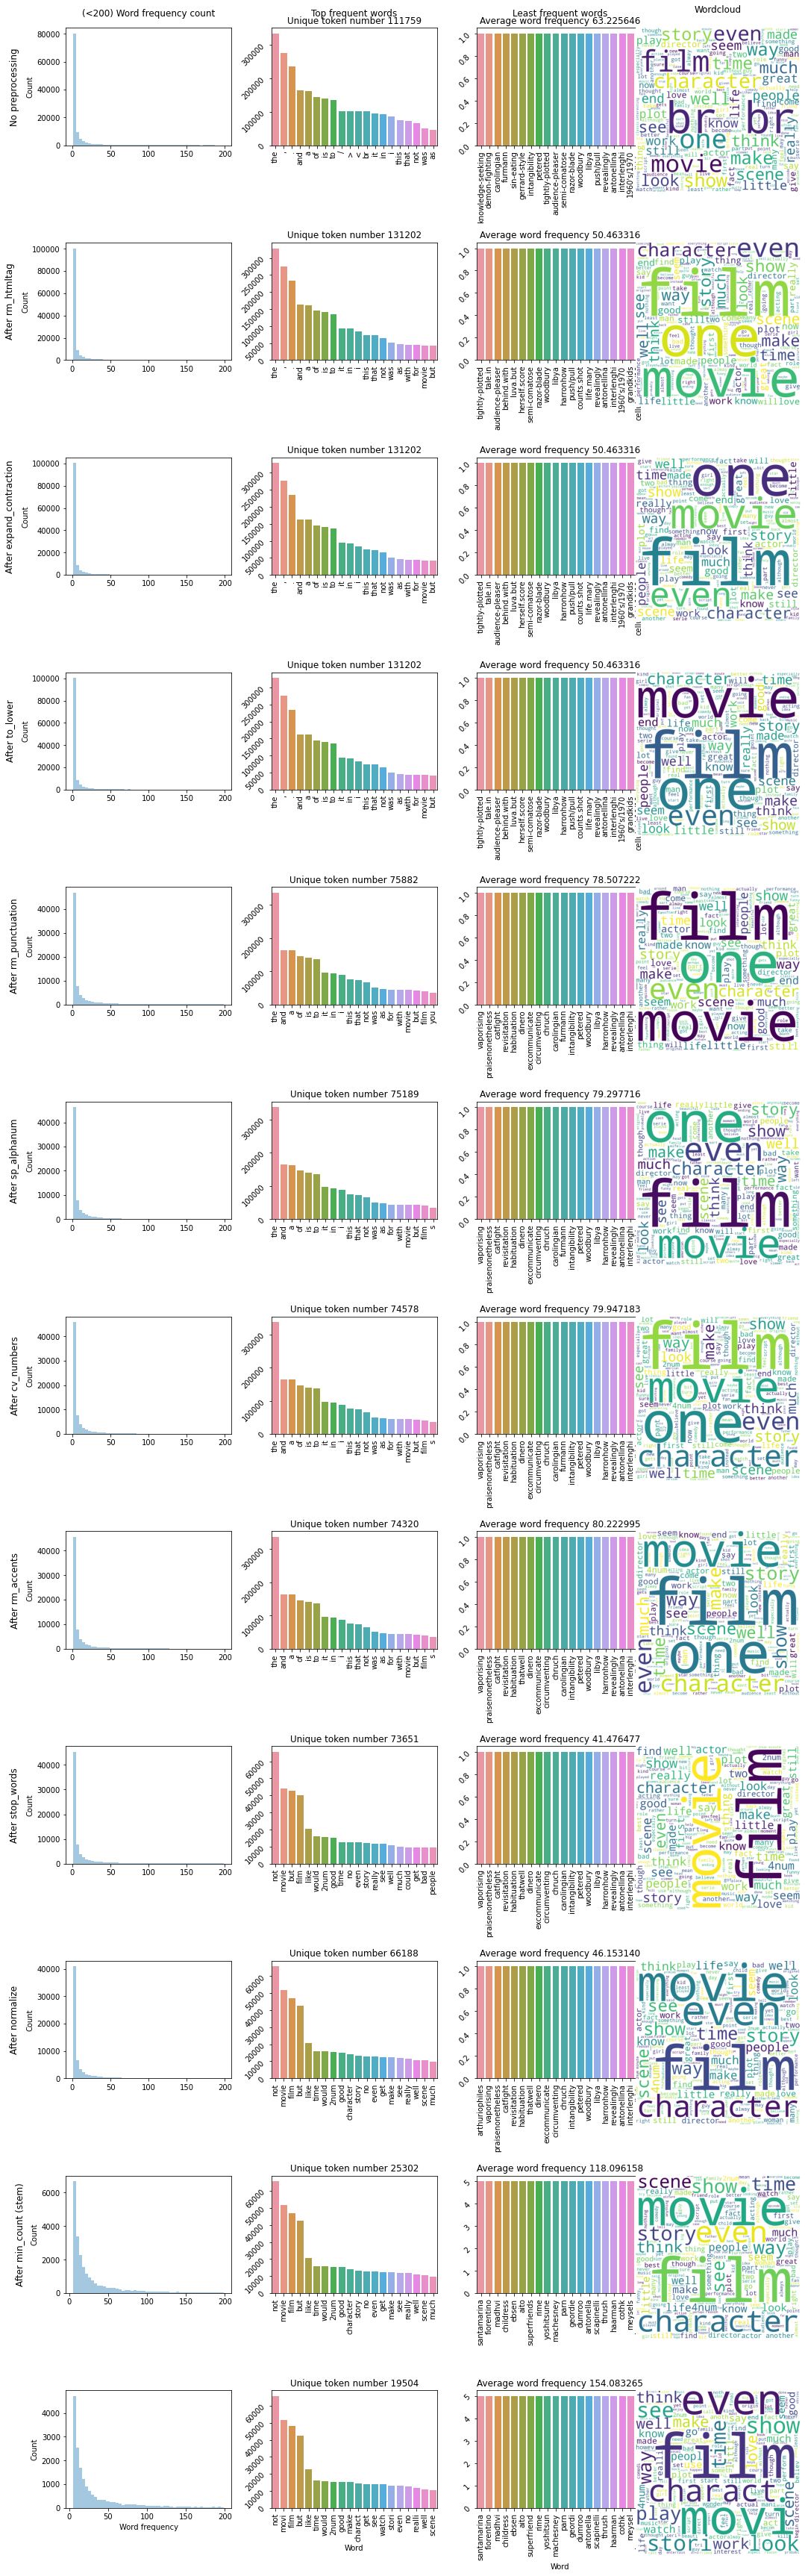

In [ ]:
if not use_cache:
    # All types of preprocessed tokens.
    steps_tokens = check_preprocessing_step(reviews_train)
    with open(prep_analysis_data_path, "w") as fp:
        json.dump(steps_tokens, fp)
else:
    try:
        _ = steps_tokens
    except:
        # Execute this line to load from file, intead of soing it all over again
        steps_tokens = read_json(prep_analysis_data_path)

num_step = len(steps_tokens)
fig, axes = plt.subplots(num_step, 4, figsize=[16, num_step * 4], facecolor="w")

pad = 5
# Top col names
cols = ["(<200) Word frequency count", "Top frequent words", "Least frequent words", "Wordcloud"]
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1.07), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
# Left row names
rows = ["No preprocessing"] + ["After %s" % (row) for row in steps_tokens[-1][0]]
rows[-1] += " (stem)"
for ax, row in zip(axes[:,0], rows):
    text = ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                       xycoords=ax.yaxis.label, textcoords='offset points',
                       size='large', ha='right', va='center', rotation=90)

# Bottom x axis
axes[-1, 0].set_xlabel("Word frequency")
axes[-1, 1].set_xlabel("Word")
axes[-1, 2].set_xlabel("Word")

for _axes, (steps, tokens) in zip(axes, steps_tokens):
    show_token_stats(tokens, axes=_axes, dist_kwargs={"norm_hist":False, "kde":False})
    # Left axis
    _axes[0].set_ylabel("Count")
fig.tight_layout()

for _axes in axes:
    ax = _axes[-1]
    box = ax.get_position()
    ax.set_position([box.x0 * 0.92, box.y0 - box.height * 0.4, box.width * 1.4 , box.height * 1.4])

In [ ]:
# showing why token number increased
tokens0 = set([w for t in steps_tokens[0][1] for w in t])
tokens1 = set([w for t in steps_tokens[1][1] for w in t])
list(tokens1 - tokens0)[:10]

['squibs.however',
 'film.see',
 '10.acting',
 'way.ebert',
 'tea.the',
 'genre.though',
 'commercial.ben',
 'come.seagal',
 'foreshadowing.edward',
 'angle.technically']

As can be seen in the above illustration of preprocessing (all of them have been tokenized):
1. Removing HTML tags get rid of br, <, > and other html characters that appeared frequently. T unique token number increased due to "." separating sentences not taken into account yet.
2. Expand contraction is an operation that will do no harm since it won't affect the semantics.
3. Lower case helps remove unique tokens and increase the average word frequency
4. removing punctuation significantly improves the result partially due to the side effect removing html tags discussed in 1
5. Separting alpha num helps fixing some typos.
6. Replacing numbers with tokens do not have huge effect on distribution but does help preserve information while normalsing data
7. Accents removal have similar effects as other operations above
8. It's clear stopwords removal removes things that appear too many times. Even though we choose to keep some negative words to preserve semantics, it changed the frequence dramatically
9. lemmatising and stemming both have great impact on the data, in this specific scenario, we choose stemming. Because we don't have enough computation power and data to train on more tokens effectivelly.

In [ ]:
if not use_cache:
    tpt = TextPreprocessTransformer(normalize="stem")
    tokens_train = tpt.fit_transform(reviews_train)
    tokens_test = tpt.transform(reviews_test)
    
    label_encoder = LabelEncoder()
    label_encoder.fit(sorted(list(set(sentiments_train))))
    labels_train = label_encoder.transform(sentiments_train)
    labels_test = label_encoder.transform(sentiments_test)

In [13]:
if not use_cache:
    small_train_size = 10000
    small_test_size = 500
    # Generate a small dataset for 1. testing 2. parameter searching
    random_idx = np.random.choice(len(tokens_train), small_train_size+small_test_size, replace=False)
    random_idx_train = set(random_idx[:small_train_size])
    random_idx_test = set(random_idx[small_train_size:])
    
    small_tokens_train = [v for i, v in enumerate(tokens_train) if i in random_idx_train]
    small_labels_train = [v for i, v in enumerate(labels_train) if i in random_idx_train]
    small_sentiments_train = [v for i, v in enumerate(sentiments_train) if i in random_idx_train]
    
    small_tokens_test = [v for i, v in enumerate(tokens_test) if i in random_idx_test]
    small_labels_test = [v for i, v in enumerate(labels_train) if i in random_idx_test]
    small_sentiments_test = [v for i, v in enumerate(sentiments_train) if i in random_idx_test]
    
    # Save processed data
    save_feather(tokens_train, labels_train, sentiments_train, train_path)
    save_feather(tokens_test, labels_test, sentiments_test, test_path)
   
    save_feather(small_tokens_train, small_labels_train, small_sentiments_train, small_train_path)
    save_feather(small_tokens_test, small_labels_test, small_sentiments_test, small_test_path)
else:
    # Load from processed data
    tokens_train, labels_train, sentiments_train = load_feather(train_path)
    tokens_test, labels_test, sentiments_test = load_feather(test_path)
    
    small_tokens_train, small_labels_train, small_sentiments_train = load_feather(small_train_path)
    small_tokens_test, small_labels_test, small_sentiments_test = load_feather(small_test_path)

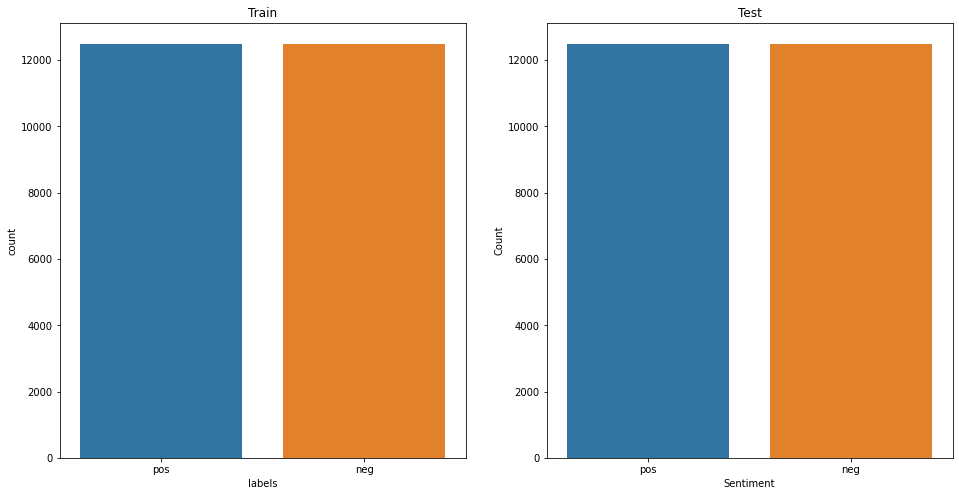

In [ ]:
# Check skewness of data
train_labels_df = pd.Series(sentiments_train, name="labels")
test_labels_df = pd.Series(sentiments_test, name="labels")

fig, axes = plt.subplots(1, 2, figsize=[16, 8])

sns.countplot(train_labels_df, ax=axes[0])
plt.xlabel("Sentiment")
plt.ylabel("Count")
axes[0].title.set_text("Train")

sns.countplot(train_labels_df, ax=axes[1])
plt.xlabel("Sentiment")
plt.ylabel("Count")
axes[1].title.set_text("Test")

# 2 - Model Implementation

## 2.1. Word Embeddings

*You are required to describe which model was implemented (i.e. Word2Vec with CBOW, FastText with SkipGram, etc.) with justification of your decision *

### 2.1.1. Data Preprocessing for Word Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

**Important**: If you are going to use the code from lab3 word2vec preprocessing. Please note that `word_list = list(set(word_list)) ` has randomness. So to make sure the word_list is the same every time you run it, you can put `word_list.sort()` after that line of code.

In [ ]:
# Profile sample time with training data
sgt = VocabSkipGramTransformer(drop_prob=0)
sgt.fit(tokens_train)

datagen = sgt.generator(tokens_train, algorithm=1)
%timeit -n 100 -r 10 next(datagen)
datagen = sgt.generator(tokens_train, algorithm=2)
%timeit -n 100 -r 10 next(datagen)
datagen = sgt.generator(tokens_train, algorithm=3)
%timeit -n 100 -r 10 next(datagen)

The slowest run took 18.91 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 10: 1.01 ms per loop
The slowest run took 25.47 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 10: 753 µs per loop
The slowest run took 10.55 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 10: 1.91 ms per loop


### 2.1.2. Build Word Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

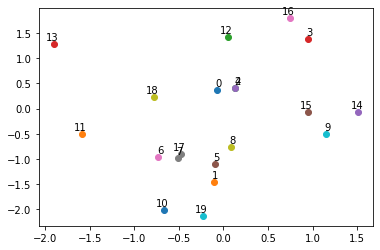

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04151540/zhua9812_word0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(0m 42s) Epoch: 250, batch: 29250, loss: 2.2235
(1m 24s) Epoch: 500, batch: 58500, loss: 2.2214
(2m 7s) Epoch: 750, batch: 87750, loss: 2.2200
(2m 49s) Epoch: 1000, batch: 117000, loss: 2.2200
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04151540/zhua9812_word1.pt
Loading net from:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04151540/zhua9812_word1.pt


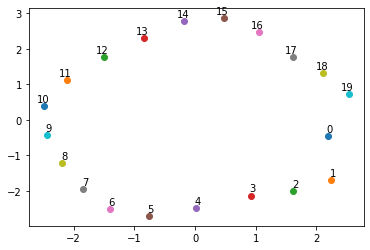

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0]]


In [ ]:
test_w2v_model = make_w2v_model(X=toy_num_data, embedding_dim=2, 
                                window=3, ckpt_base="test_w2v", addtime=True)
# Before
vocab_list = test_w2v_model.data_transformer.token_list
plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().clone().cpu().numpy())), vocab_list)
plt.show()

# Overfit the small dataset
test_w2v_model.train(train_data=toy_num_data, epochs=1000, batch_size=2, 
                     epoch_display_interval=250, ckpt_interval=1000)

# Test loading
test_w2v_model.load_model()

# After
plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().clone().cpu().numpy())), vocab_list)
plt.show()
print(toy_num_data)

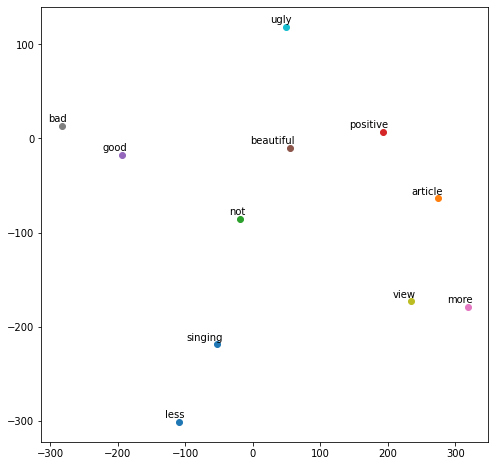

    (0m 2s) Batch: 1000, loss: 1.6641
    (0m 4s) Batch: 2000, loss: 1.5534


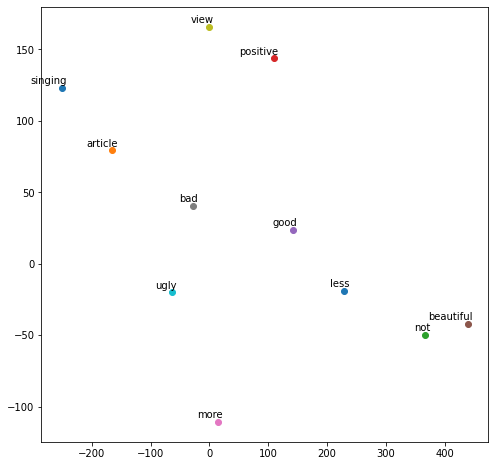

In [ ]:
# Also a test model 

test_embedding_dim = 6
test_window = 3
perplexity = 3
test_w2v_model = make_w2v_model(X=toy_data, embedding_dim=test_embedding_dim, window=test_window, ckpt_base="test_w2v")
_ = plot_w2v_topk(test_w2v_model, toy_data, method="TSNE", k=100, perplexity=perplexity)
# _ = plot_w2v_topk(test_w2v_model, toy_data, method="PCA", k=100)
# vocab_list = test_w2v_model.data_transformer.token_list
# plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().numpy())), vocab_list)
# plt.show()
test_w2v_model.train(train_data=toy_data, epochs=2000, batch_display_interval=1000)
_ = plot_w2v_topk(test_w2v_model, toy_data, method="TSNE", k=100, perplexity=perplexity)
# _ = plot_w2v_topk(test_w2v_model, toy_data, method="PCA", k=100)
# vocab_list = test_w2v_model.data_transformer.token_list
# plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().numpy())), vocab_list)
# plt.show()

# Negative words seems to have clustered together

Tune learning rate

In [68]:
# All converged to similar values
experiment_tag = "lr"
add_w2v_model_config(experiment_tag, lr=1e-4)
add_w2v_model_config(experiment_tag, lr=5e-4)
add_w2v_model_config(experiment_tag, lr=1e-3)
add_w2v_model_config(experiment_tag, lr=5e-3)
add_w2v_model_config(experiment_tag, lr=1e-2)
add_w2v_model_config(experiment_tag, lr=1e-1)
run_w2v_model_experiments(experiment_tag, w2v_configs_path, small_train_path, small_test_path)

Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Same config exists
(08, 04) Response: {}


wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


==================== experiment ====================
run id 2190jz3y
{'batch_size': 1024, 'ckpt_root': 'experiments', 'epochs': 50, 'experiment_tag': 'lr', 'lr': 0.0001, 'model': 'w2v', 'w2v_embedding_dim': 64}
----------------------------------------------------
(0m 40s) Epoch: 1, batch: 2944, loss: 8.2937
Validation - epoch 1:
    Loss: 7.7252
    accuracy: 2.21%
    F1: 0.0221
Saving net to:  experiments/word/zhua9812_wordbest.pt


/home/Dovermore/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(1m 18s) Epoch: 2, batch: 5888, loss: 7.7648
Validation - epoch 2:
    Loss: 7.6512
    accuracy: 2.29%
    F1: 0.0229
Saving net to:  experiments/word/zhua9812_wordbest.pt
(1m 45s) Epoch: 3, batch: 8832, loss: 7.6905
Validation - epoch 3:
    Loss: 7.6437
    accuracy: 2.38%
    F1: 0.0238
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 12s) Epoch: 4, batch: 11776, loss: 7.6538
Validation - epoch 4:
    Loss: 7.6437
    accuracy: 2.32%
    F1: 0.0232
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 38s) Epoch: 5, batch: 14720, loss: 7.6283
Validation - epoch 5:
    Loss: 7.6425
    accuracy: 2.32%
    F1: 0.0232
Saving net to:  experiments/word/zhua9812_wordbest.pt
(3m 5s) Epoch: 6, batch: 17664, loss: 7.6076
Validation - epoch 6:
    Loss: 7.6390
    accuracy: 2.22%
    F1: 0.0222
(3m 31s) Epoch: 7, batch: 20608, loss: 7.5909
Validation - epoch 7:
    Loss: 7.6365
    accuracy: 2.38%
    F1: 0.0238
(3m 58s) Epoch: 8, batch: 23552, loss: 7.5758
Validation - epoch 8:

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


==================== experiment ====================
run id 4d0v8ivl
{'batch_size': 1024, 'ckpt_root': 'experiments', 'epochs': 50, 'experiment_tag': 'lr', 'lr': 0.0005, 'model': 'w2v', 'w2v_embedding_dim': 64}
----------------------------------------------------
(0m 40s) Epoch: 1, batch: 2944, loss: 8.2962
Validation - epoch 1:
    Loss: 7.7186
    accuracy: 2.06%
    F1: 0.0206
Saving net to:  experiments/word/zhua9812_wordbest.pt


/home/Dovermore/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(1m 15s) Epoch: 2, batch: 5888, loss: 7.7633
Validation - epoch 2:
    Loss: 7.6555
    accuracy: 2.11%
    F1: 0.0211
Saving net to:  experiments/word/zhua9812_wordbest.pt
(1m 41s) Epoch: 3, batch: 8832, loss: 7.6915
Validation - epoch 3:
    Loss: 7.6491
    accuracy: 2.28%
    F1: 0.0228
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 7s) Epoch: 4, batch: 11776, loss: 7.6550
Validation - epoch 4:
    Loss: 7.6470
    accuracy: 2.22%
    F1: 0.0222
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 33s) Epoch: 5, batch: 14720, loss: 7.6301
Validation - epoch 5:
    Loss: 7.6405
    accuracy: 2.22%
    F1: 0.0222
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 59s) Epoch: 6, batch: 17664, loss: 7.6107
Validation - epoch 6:
    Loss: 7.6430
    accuracy: 2.22%
    F1: 0.0222
(3m 25s) Epoch: 7, batch: 20608, loss: 7.5944
Validation - epoch 7:
    Loss: 7.6458
    accuracy: 2.22%
    F1: 0.0222
(3m 51s) Epoch: 8, batch: 23552, loss: 7.5803
Validation - epoch 8:

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


==================== experiment ====================
run id 283l0qvb
{'batch_size': 1024, 'ckpt_root': 'experiments', 'epochs': 50, 'experiment_tag': 'lr', 'lr': 0.001, 'model': 'w2v', 'w2v_embedding_dim': 64}
----------------------------------------------------
(0m 40s) Epoch: 1, batch: 2944, loss: 8.2951
Validation - epoch 1:
    Loss: 7.7096
    accuracy: 2.19%
    F1: 0.0219
Saving net to:  experiments/word/zhua9812_wordbest.pt


/home/Dovermore/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(1m 16s) Epoch: 2, batch: 5888, loss: 7.7627
Validation - epoch 2:
    Loss: 7.6495
    accuracy: 2.27%
    F1: 0.0227
Saving net to:  experiments/word/zhua9812_wordbest.pt
(1m 42s) Epoch: 3, batch: 8832, loss: 7.6898
Validation - epoch 3:
    Loss: 7.6452
    accuracy: 2.32%
    F1: 0.0232
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 8s) Epoch: 4, batch: 11776, loss: 7.6538
Validation - epoch 4:
    Loss: 7.6384
    accuracy: 2.09%
    F1: 0.0209
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 34s) Epoch: 5, batch: 14720, loss: 7.6298
Validation - epoch 5:
    Loss: 7.6486
    accuracy: 2.13%
    F1: 0.0213
(3m 0s) Epoch: 6, batch: 17664, loss: 7.6109
Validation - epoch 6:
    Loss: 7.6470
    accuracy: 2.18%
    F1: 0.0218
(3m 26s) Epoch: 7, batch: 20608, loss: 7.5941
Validation - epoch 7:
    Loss: 7.6461
    accuracy: 2.20%
    F1: 0.0220
(3m 52s) Epoch: 8, batch: 23552, loss: 7.5803
Validation - epoch 8:
    Loss: 7.6557
    accuracy: 2.02%
    F1: 0.0202
(4

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


==================== experiment ====================
run id 12uq5l7v
{'batch_size': 1024, 'ckpt_root': 'experiments', 'epochs': 50, 'experiment_tag': 'lr', 'lr': 0.005, 'model': 'w2v', 'w2v_embedding_dim': 64}
----------------------------------------------------
(0m 39s) Epoch: 1, batch: 2944, loss: 8.2945
Validation - epoch 1:
    Loss: 7.7168
    accuracy: 2.07%
    F1: 0.0207
Saving net to:  experiments/word/zhua9812_wordbest.pt


/home/Dovermore/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(1m 16s) Epoch: 2, batch: 5888, loss: 7.7611
Validation - epoch 2:
    Loss: 7.6567
    accuracy: 2.12%
    F1: 0.0212
Saving net to:  experiments/word/zhua9812_wordbest.pt
(1m 42s) Epoch: 3, batch: 8832, loss: 7.6898
Validation - epoch 3:
    Loss: 7.6502
    accuracy: 2.27%
    F1: 0.0227
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 8s) Epoch: 4, batch: 11776, loss: 7.6551
Validation - epoch 4:
    Loss: 7.6461
    accuracy: 2.25%
    F1: 0.0225
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 34s) Epoch: 5, batch: 14720, loss: 7.6314
Validation - epoch 5:
    Loss: 7.6504
    accuracy: 2.11%
    F1: 0.0211
(3m 0s) Epoch: 6, batch: 17664, loss: 7.6125
Validation - epoch 6:
    Loss: 7.6471
    accuracy: 2.12%
    F1: 0.0212
(3m 26s) Epoch: 7, batch: 20608, loss: 7.5965
Validation - epoch 7:
    Loss: 7.6532
    accuracy: 2.17%
    F1: 0.0217
(3m 51s) Epoch: 8, batch: 23552, loss: 7.5819
Validation - epoch 8:
    Loss: 7.6458
    accuracy: 2.27%
    F1: 0.0227
(4

wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


==================== experiment ====================
run id 2gennbqb
{'batch_size': 1024, 'ckpt_root': 'experiments', 'epochs': 50, 'experiment_tag': 'lr', 'lr': 0.01, 'model': 'w2v', 'w2v_embedding_dim': 64}
----------------------------------------------------
(0m 40s) Epoch: 1, batch: 2944, loss: 8.2934
Validation - epoch 1:
    Loss: 7.7140
    accuracy: 2.08%
    F1: 0.0208
Saving net to:  experiments/word/zhua9812_wordbest.pt


/home/Dovermore/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(1m 16s) Epoch: 2, batch: 5888, loss: 7.7634
Validation - epoch 2:
    Loss: 7.6665
    accuracy: 2.16%
    F1: 0.0216
Saving net to:  experiments/word/zhua9812_wordbest.pt
(1m 42s) Epoch: 3, batch: 8832, loss: 7.6893
Validation - epoch 3:
    Loss: 7.6521
    accuracy: 2.09%
    F1: 0.0209
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 8s) Epoch: 4, batch: 11776, loss: 7.6530
Validation - epoch 4:
    Loss: 7.6398
    accuracy: 2.21%
    F1: 0.0221
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 34s) Epoch: 5, batch: 14720, loss: 7.6282
Validation - epoch 5:
    Loss: 7.6366
    accuracy: 2.19%
    F1: 0.0219
Saving net to:  experiments/word/zhua9812_wordbest.pt
(3m 0s) Epoch: 6, batch: 17664, loss: 7.6086
Validation - epoch 6:
    Loss: 7.6439
    accuracy: 2.15%
    F1: 0.0215
(3m 26s) Epoch: 7, batch: 20608, loss: 7.5920
Validation - epoch 7:
    Loss: 7.6420
    accuracy: 2.17%
    F1: 0.0217
(3m 53s) Epoch: 8, batch: 23552, loss: 7.5771
Validation - epoch 8:


wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


==================== experiment ====================
run id tjhyi7i1
{'batch_size': 1024, 'ckpt_root': 'experiments', 'epochs': 50, 'experiment_tag': 'lr', 'lr': 0.1, 'model': 'w2v', 'w2v_embedding_dim': 64}
----------------------------------------------------
(0m 40s) Epoch: 1, batch: 2944, loss: 8.2861
Validation - epoch 1:
    Loss: 7.6993
    accuracy: 2.16%
    F1: 0.0216
Saving net to:  experiments/word/zhua9812_wordbest.pt


/home/Dovermore/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(1m 15s) Epoch: 2, batch: 5888, loss: 7.7626
Validation - epoch 2:
    Loss: 7.6480
    accuracy: 1.97%
    F1: 0.0197
Saving net to:  experiments/word/zhua9812_wordbest.pt
(1m 42s) Epoch: 3, batch: 8832, loss: 7.6893
Validation - epoch 3:
    Loss: 7.6383
    accuracy: 2.27%
    F1: 0.0227
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 8s) Epoch: 4, batch: 11776, loss: 7.6511
Validation - epoch 4:
    Loss: 7.6357
    accuracy: 2.18%
    F1: 0.0218
Saving net to:  experiments/word/zhua9812_wordbest.pt
(2m 34s) Epoch: 5, batch: 14720, loss: 7.6258
Validation - epoch 5:
    Loss: 7.6439
    accuracy: 2.33%
    F1: 0.0233
(3m 1s) Epoch: 6, batch: 17664, loss: 7.6051
Validation - epoch 6:
    Loss: 7.6405
    accuracy: 2.18%
    F1: 0.0218
(3m 27s) Epoch: 7, batch: 20608, loss: 7.5886
Validation - epoch 7:
    Loss: 7.6454
    accuracy: 2.20%
    F1: 0.0220
(3m 53s) Epoch: 8, batch: 23552, loss: 7.5731
Validation - epoch 8:
    Loss: 7.6473
    accuracy: 2.18%
    F1: 0.0218
(4

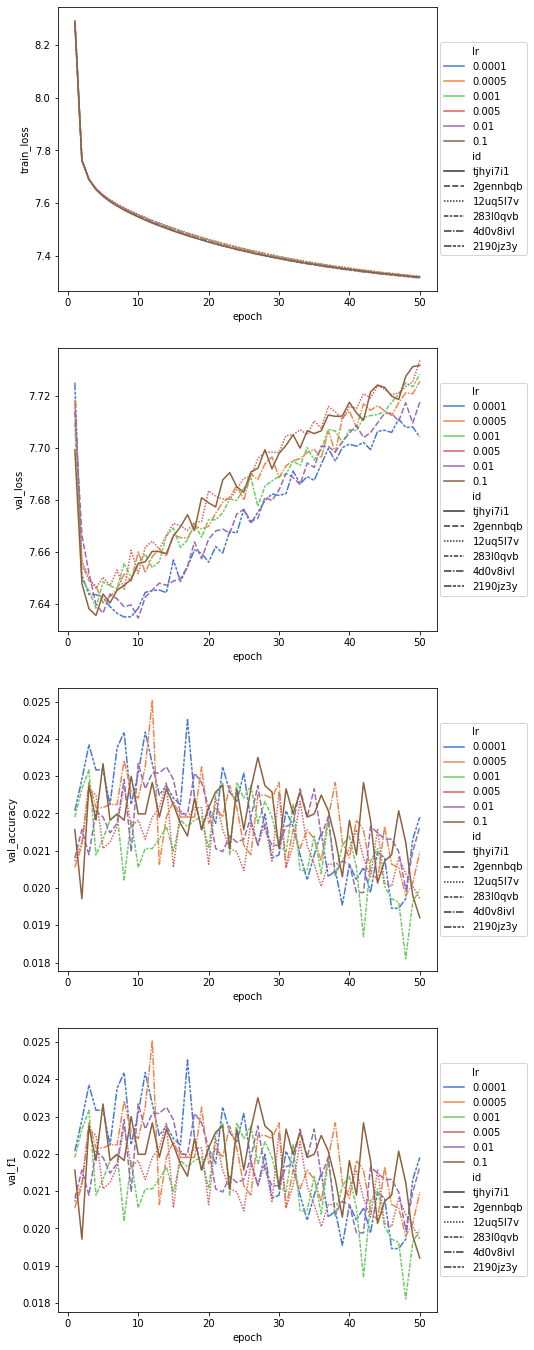

In [70]:
experiment_tag = "lr"
performance = ["train_loss", "val_loss", "val_accuracy", "val_f1"]
runs = api.runs(wandb_api_key, {"config.experiment_tag": experiment_tag, "config.model": "w2v"})
df = get_runs_df(runs, attr=experiment_tag, performances=performance)
fig = plot_runs_df(df, attr=experiment_tag, performances=performance)
ax = fig.axes[0]

# Value pretty much the same, with minor difference, 
# we will choose a larger value 0.01 for hoply faster convergence
# in the full dataset


Tune embedding_dim

In [15]:
# All converged to similar values
lr = 1e-2
# Looks like it overfits rapidly, so we use a smaller epochs
epochs = 20

experiment_tag = "w2v_embedding_dim"
add_w2v_model_config(experiment_tag, lr=lr, w2v_embedding_dim= 32, epochs=epochs)
add_w2v_model_config(experiment_tag, lr=lr, w2v_embedding_dim= 64, epochs=epochs)
add_w2v_model_config(experiment_tag, lr=lr, w2v_embedding_dim=128, epochs=epochs) # Overfits
add_w2v_model_config(experiment_tag, lr=lr, w2v_embedding_dim= 16, epochs=epochs)
add_w2v_model_config(experiment_tag, lr=lr, w2v_embedding_dim=  8, epochs=epochs)
run_w2v_model_experiments(experiment_tag, w2v_configs_path, small_train_path, small_test_path)

Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Same config exists
Adding config to file - config/w2v_configs.json.
Adding new config
Adding config to file - config/w2v_configs.json.
Adding new config
(16, 44) Response: {}


wandb: Wandb version 0.8.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


==================== experiment ====================
run id vp3yv6sm
{'batch_size': 1024, 'ckpt_root': 'experiments', 'epochs': 20, 'experiment_tag': 'w2v_embedding_dim', 'lr': 0.01, 'model': 'w2v', 'w2v_embedding_dim': 16}
----------------------------------------------------
(2m 26s) Epoch: 1, batch: 11488, loss: 8.0712
(2m 26s) Validation - epoch 1:
    Loss: 7.6233
    accuracy: 2.32%
    F1: 0.0232
Saving net to:  experiments/word/zhua9812_wordbest.pt


/home/Dovermore/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(4m 14s) Epoch: 2, batch: 22976, loss: 7.7878
(4m 14s) Validation - epoch 2:
    Loss: 7.6023
    accuracy: 2.33%
    F1: 0.0233
Saving net to:  experiments/word/zhua9812_wordbest.pt
(6m 3s) Epoch: 3, batch: 34464, loss: 7.7670
(6m 3s) Validation - epoch 3:
    Loss: 7.5918
    accuracy: 2.34%
    F1: 0.0234
Saving net to:  experiments/word/zhua9812_wordbest.pt
(7m 52s) Epoch: 4, batch: 45952, loss: 7.7581
(7m 52s) Validation - epoch 4:
    Loss: 7.5834
    accuracy: 2.35%
    F1: 0.0235
Saving net to:  experiments/word/zhua9812_wordbest.pt


KeyboardInterrupt: 

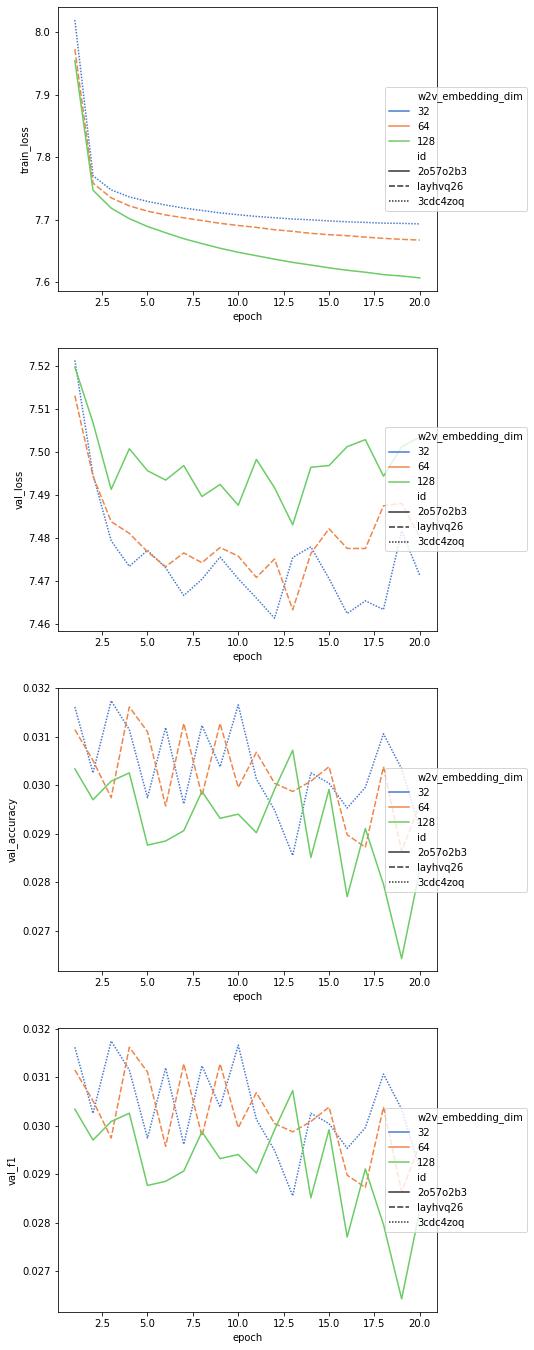

In [13]:
experiment_tag = "w2v_embedding_dim"
performance = ["train_loss", "val_loss", "val_accuracy", "val_f1"]
runs = api.runs(wandb_api_key, {"config.experiment_tag": experiment_tag, "config.model": "w2v"})
df = get_runs_df(runs, attr=experiment_tag, performances=performance)
fig = plot_runs_df(df, attr=experiment_tag, performances=performance)
ax = fig.axes[0]

# Value pretty much the same, with minor difference, 
# we will choose a larger value 0.01 for hoply faster convergence
# in the full dataset
embedding_dim = 32

Train net for experiment of next stage

In [ ]:
exp_w2v_model = make_w2v_model(small_tokens_train, embedding_dim, window, drop_prob)
# 100 is the most I can run, else colab disconnects
exp_w2v_model.train(train_data=tokens_train, epochs=100, batch_size=1024, 
                batch_display_interval=10000, epoch_display_interval=1, ckpt_interval=1)

### 2.1.3. Train Word Embeddings Model

Train actual net

In [ ]:
embedding_dim, window, drop_prob = 64, 5, 0
w2v_model = make_w2v_model(tokens_train, embedding_dim, window, drop_prob)
# 100 is the most I can run, else colab disconnects
w2v_model_trails = w2v_model.train(train_data=tokens_train, epochs=100, batch_size=1024, 
                                   batch_display_interval=10000, epoch_display_interval=1, ckpt_interval=1)

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_word0.h5


### 2.1.4. Save Word Embeddings Model

In [ ]:
# Adding _ to the end because it should already be saved once
w2v_model.save_model("")

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_wordbest_.h5


### 2.1.5. Load Word Embeddings Model

In [ ]:
# Setup
w2v_model_load = make_w2v_model(tokens_train, embedding_dim, window, drop_prob)
w2v_model_load.load_model("")
w2v_model_load.mode(False)

Loading net from:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_wordbest.h5


## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

In [ ]:
cet = VocabCharacterTransformer().fit(toy_num_data)
cet.transform(toy_num_data)
# It works

### 2.2.2. Build Character Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [ ]:
experiment_tag = "lr"
add_char_model_config(experiment_tag, lr=1e-3)
run_char_model_experiments(experiment_tag, char_configs_path, small_train_path, small_test_path)

Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/char_configs.json.
Same config exists


==================== experiment ====================
run id 6h6gf2e3
{'batch_size': 1024, 'char_dropout': 0, 'char_hidden_size': 128, 'char_num_layers': 1, 'char_rnn_type': 'lstm', 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1/experiments', 'epochs': 100, 'experiment_tag': 'lr', 'lr': 0.001, 'model': 'char'}
----------------------------------------------------
Loading net from:  /content/drive/My Drive/COMP5046-assignment1/experiments/word/zhua9812_wordbest.pt
Validation - epoch 1:
    Loss: 0.7900
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/experiments/character/zhua9812_characterbest.pt
(0m 57s) Epoch: 1, batch: 302, loss: 0.8624


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharacterEmbedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation - epoch 2:
    Loss: 0.6947
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/experiments/character/zhua9812_characterbest.pt
(1m 52s) Epoch: 2, batch: 604, loss: 0.7506


KeyboardInterrupt: ignored

In [ ]:
test_embedding = test_w2v_model.net.embedding
test_char_model = make_char_model(toy_data, test_embedding, ckpt_base="test_char", addtime=True)
_ = test_char_model.train(train_data=toy_data, epochs=5000, batch_display_interval=1000)

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_char04141224/zhua9812_character0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharacterEmbedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


    (0m 9s) Batch: 1000, loss: 0.0009
    (0m 17s) Batch: 2000, loss: 0.0001
    (0m 26s) Batch: 3000, loss: 0.0000
    (0m 34s) Batch: 4000, loss: 0.0000
    (0m 42s) Batch: 5000, loss: 0.0000


In [ ]:
experiment_tag = "char_dropout"
add_char_model_config(experiment_tag=experiment_tag, char_dropout=0, lr=lr)
add_char_model_config(experiment_tag=experiment_tag, char_dropout=0.25, lr=lr)
add_char_model_config(experiment_tag=experiment_tag, char_dropout=0.5, lr=lr)

Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/char_configs.json.
File Not exist, creating new file.
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/char_configs.json.
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/char_configs.json.


{'batch_size': 1024,
 'char_dropout': 0,
 'char_hidden_size': 128,
 'char_num_layers': 1,
 'char_rnn_type': 'lstm',
 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1',
 'epochs': 100,
 'lr': 0.0005}

In [ ]:
run_char_model_experiments(char_configs_path, small_train_path, small_test_path)

==================== experiment ====================
{'char_rnn_type': 'lstm', 'char_num_layers': 1, 'char_dropout': 0, 'char_hidden_size': 128, 'lr': 0.001, 'epochs': 100, 'batch_size': 1024, 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1'}
----------------------------------------------------
Loading net from:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_wordbest.pt


Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharacterEmbedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(0m 14s) Epoch: 1, batch: 62, loss: 0.9906
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.pt
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character1.pt
(0m 27s) Epoch: 2, batch: 124, loss: 0.9569
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.pt
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character2.pt
(0m 39s) Epoch: 3, batch: 186, loss: 0.9128
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.pt
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character3.pt
(0m 51s) Epoch: 4, batch: 248, loss: 0.8825
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.pt
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character4.pt
(1m 4s) Epoch: 5, batch: 310, loss: 0.8606
Saving net to:  /c

KeyboardInterrupt: ignored

### 2.1.4. Train Character Embeddings Model

In [ ]:
embedding = w2v_model_load.net.embedding
char_model = make_char_model(tokens_train, embedding=embedding, hidden_size=128)
char_model_trails = char_model.train(train_data=tokens_train, epochs=1, batch_display_interval=5000, 
                                     epoch_display_interval=1, ckpt_interval=1)

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character0.h5
(11m 16s) Epoch: 1, batch: 2916, loss: 0.6825
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character1.h5


### 2.1.5. Save Character Embeddings Model

In [ ]:
char_model.save_model("best_")

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.h5


### 2.1.6. Load Character Embeddings Model

In [ ]:
embedding = w2v_model_load.net.embedding
char_model_load = make_char_model(tokens_train, embedding, ckpt_base="character")
char_model_load.load_model("best")
char_model_load.mode(False)

Loading net from:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.h5


## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

In [ ]:
# This process is done in the model class automatically

*You are required to describe how hyperparameters were decided with justification of your decision.*

### 2.3.2. Build Sequence Model

Tune learning rate

In [ ]:
# All converged to similar values
experiment_tag = "lr"
add_seq_model_config(experiment_tag, lr=1e-4)
add_seq_model_config(experiment_tag, lr=5e-4)
add_seq_model_config(experiment_tag, lr=1e-3)
add_seq_model_config(experiment_tag, lr=5e-3)
add_seq_model_config(experiment_tag, lr=1e-2)
add_seq_model_config(experiment_tag, lr=1e-1)
run_seq_model_experiments(experiment_tag, seq_configs_path, small_train_path, small_test_path)

Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/w2v_configs.json.
Same config exists
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/w2v_configs.json.
Same config exists
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/w2v_configs.json.
Same config exists
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/w2v_configs.json.
Same config exists
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/w2v_configs.json.
Same config exists
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/w2v_configs.json.
Same config exists
[{'batch_size': 1024, 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1/experiments', 'epochs': 50, 'experiment_tag': 'lr', 'id': None, 'lr': 0.0001, 'model': 'w2v', 'w2v_embedding_dim': 64}, {'batch_size': 1024, 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1/experiments', 'epochs': 50, 'experiment_t

==================== experiment ====================
run id 108d2iov
{'batch_size': 1024, 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1/experiments', 'epochs': 50, 'experiment_tag': 'lr', 'lr': 0.0001, 'model': 'w2v', 'w2v_embedding_dim': 64}
----------------------------------------------------
153
11860


KeyboardInterrupt: ignored

(7.3, 7.35)

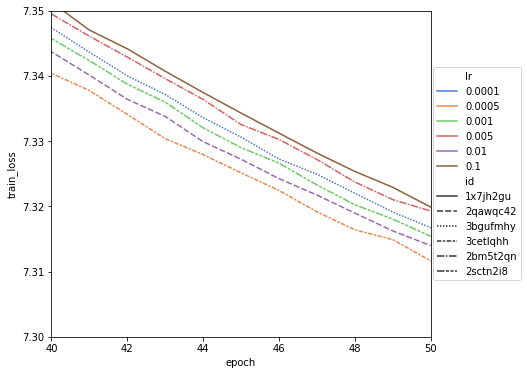

In [ ]:
experiment_tag = "lr"
performance = "train_loss"
runs = api.runs(wandb_api_key, {"config.experiment_tag": experiment_tag, "config.model": "seq"})
df = get_runs_df(runs, attr=experiment_tag, performances=performance)
fig = plot_runs_df(df, attr=experiment_tag, performances=performance)
ax = fig.axes[0]
ax.set_xlim([40, 50])
ax.set_ylim([7.3, 7.35])

# Value pretty much the same, with minor difference, 
# we will choose a larger value 0.01 for hoply faster convergence
# in the full dataset
lr = 1e-2

### 2.3.3. Train Sequence Model

In [ ]:
experiment_tag = "lr"
add_seq_model_config(experiment_tag=experiment_tag", lr=1e-3)
add_seq_model_config(experiment_tag=experiment_tag", lr=5e-3) # -> converges the fastest
add_seq_model_config(experiment_tag=experiment_tag", lr=5e-4)

Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/seq_configs.json.
File not exist. Creating new file.
Adding new config
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/seq_configs.json.
Adding new config
Adding config to file - /content/drive/My Drive/COMP5046-assignment1/config/seq_configs.json.
Adding new config


{'batch_size': 1024,
 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1/experiments',
 'epochs': 100,
 'experiment_tag': 'lr',
 'id': None,
 'lr': 0.0005,
 'model': 'seq',
 'seq_dropout': 0,
 'seq_hidden_size': 32,
 'seq_num_layers': 1,
 'seq_rnn_type': 'lstm'}

In [ ]:
run_seq_model_experiments(experiment_tag, seq_configs_path, small_train_path, small_test_path)

==================== experiment ====================
run id 2ocbilpt
{'batch_size': 1024, 'ckpt_root': '/content/drive/My Drive/COMP5046-assignment1/experiments', 'epochs': 100, 'experiment_tag': 'lr', 'lr': 0.001, 'model': 'seq', 'seq_dropout': 0, 'seq_hidden_size': 32, 'seq_num_layers': 1, 'seq_rnn_type': 'lstm'}
----------------------------------------------------
Loading net from:  /content/drive/My Drive/COMP5046-assignment1/experiments/word/zhua9812_wordbest.pt
Loading net from:  /content/drive/My Drive/COMP5046-assignment1/experiments/character/zhua9812_characterbest.pt
Validation - epoch 1:
    Loss: 0.6869
    accuracy: 54.20%
    F1: 0.2954
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/experiments/sequence/zhua9812_sequencebest.pt
(2m 47s) Epoch: 1, batch: 3, loss: 0.5767


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SequenceNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Validation - epoch 2:
    Loss: 0.6909
    accuracy: 54.60%
    F1: 0.5201
(5m 28s) Epoch: 2, batch: 6, loss: 0.5656


KeyboardInterrupt: ignored

In [ ]:
# Test model
test_hidden_size = 3
test_char_net = test_char_model.net
seq_model = make_sequence_model(toy_full_data11, test_embedding, test_char_net, test_hidden_size, 
                              ckpt_base="test_seq", addtime=True)
seq_model.train(train_data=toy_full_data11, val_data=toy_full_data_test, epochs=3200, batch_size=6, 
            epoch_display_interval=200, ckpt_interval=10000, epoch_validation_interval=400,
            wandb_log=True)

In [ ]:
# Actual model
hidden_size = embedding_dim // 4
seq_model = make_sequence_model([tokens_train, labels_train], w2v_model_load.net.embedding, 
                               char_model_load.net, hidden_size, ckpt_base="seq")
seq_net_trail = seq_model.train([tokens_train, labels_train], 100, batch_display_interval=5000, 
                              epoch_display_interval=1, ckpt_interval=1)

### 2.3.4. Save Sequence Model

In [ ]:
seq_model.save_model("best_")

### 2.3.5. Load Sequence Model

In [ ]:
# Please comment your code
hidden_size = w2v_model_load.net.embedding.embedding_dim / 4
seq_model = make_sequence_model([tokens_train, labels_train], w2v_model_load.net.embedding, 
                            char_model_load.net, hidden_size, ckpt_base="seq")
seq_model.load_model("best")
seq_model.mode(False)

NameError: ignored

# 3 - Evaluation

(*Please show your empirical evidence*)

## 3.1. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.

In [ ]:
# Please comment your code

## 3.2. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.*

In [ ]:
# Please comment your code


3

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [28]:
# install some other necessary libraries
# Expand contractions
%pip install unicode contractions torchviz wandb chart_studio plotly cufflinks nltk gensim wordcloud

Note: you may need to restart the kernel to use updated packages.


In [1]:
!wandb login 313fbc32f5d8eafb89fc6611be0e05e4a71ef77f
# Setup saving and loading
from google.colab import files, drive

# Setup basic libraries
from pathlib import Path
import copy
from copy import deepcopy
import re
import os
import time
from datetime import datetime
import math
from collections import Counter
from random import getrandbits, sample, randint
import json
# For sending emails
import smtplib
import ssl
from email.message import EmailMessage

# Standard import
import numpy as np
import pandas as pd

# Sklearn for transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin
# Sklearn for visualisation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
# Sklearn for evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from unidecode import unidecode

# Html tag removal
from bs4 import BeautifulSoup
# Contraction expansion
import contractions

# Stemming/frequency count
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
from nltk.stem import PorterStemmer 
from nltk import FreqDist

from gensim.parsing.preprocessing import split_alphanum

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# For some reason these didn't work.
# import cufflinks as cf
# from plotly.offline import init_notebook_mode
# # init_notebook_mode()
# cf.go_offline()
# # cf.set_config_file(world_readable=True, theme='pearl')

# Torch
import torch
from torch import nn
from torch.utils import data
from torch.optim import Adam
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_sequence

# Computation graph
from torchviz import make_dot

# Logging
import wandb

# Reduce precision to train faster
torch.set_default_dtype(torch.float)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda")
# device = torch.device("cpu")
print("device is ", device)

# For reproducibility
# Also the ultimita solution to universe -- The Hitchhiker's Guide to the Galaxy
torch.manual_seed(42)
np.random.seed(42)

wandb: Appending key for api.wandb.ai to your netrc file: /home/Dovermore/.netrc
Successfully logged in to Weights & Biases!


[nltk_data] Downloading package punkt to /home/Dovermore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Dovermore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Dovermore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
unable to import 'smart_open.gcs', disabling that module


device is  cuda


In [2]:
## Setup some variables
# Prepare some Toy data
toy_token_1data = [["hello"]]
toy_token_10data = [["hello", "below", "allow", "law", "low", "all", "halo", 
                     "hellobelowallow", "lawlow", "halo"]]

toy_token_data11 = [
                      ["good", "article"],
                      ["beautiful", "article", "good"],
                      ["beautiful", "singing", "more"],
                      ["not", "bad", "view"],
                      ["not", "ugly", "singing", "positive"],
                      ["more", "positive", "singing"],
                      ["less", "positive", "article"],
                      ["bad", "singing"],
                      ["not", "positive", "article"],
                      ["not", "good", "singing"],
                      ["ugly", "view"],
                      ]
toy_sentiment_data11 = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

toy_token_data_test = [
                    # Test if it can handle unseen words (should ignore it)
                      ["more", "impressive", "singing", "not", "bad"],

                      ["not", "ugly", "article"],
                      ["beautiful", "view"],
                      ["more", "good", "singing", "positive"],
                      ["less", "bad", "view"],
                      ["less", "good", "article"],
                      ["not", "beautiful", "view"],
                      ]
toy_sentiment_data_test = [1, 1, 1, 1, 0, 0, 0]

toy_full_data11 = [toy_token_data11, toy_sentiment_data11]
toy_full_data_test = [toy_token_data_test, toy_sentiment_data_test]
toy_data = toy_token_data11
toy_num_data = np.array(list(range(20)) * 2 + [0]).reshape(1, -1).tolist()

# Setup drive path
try:
    root_path
except:
    root_path = Path(".")
    # drive.mount('/content/drive')
    # root_path = Path("/content/drive/My Drive/COMP5046-assignment1/")

# Processed train and test data
train_path = root_path/"data"/"train.feather"
test_path = root_path/"data"/"test.feather"
small_train_path = root_path/"data"/"small_train.feather"
small_test_path = root_path/"data"/"small_test.feather"
prep_analysis_data_path = root_path/"data"/"pad.json"
use_cache = True

# List of generic hyperparameters
# optimizer: lr, *args, **kwargs
# epochs, batch_size
# w2v: embedding_dim, window, drop_prob
w2v_configs_path = root_path/"config"/"w2v_configs.json"
# char: ?[gru, lstm, rnn], hidden_size, dropout, num_layers
char_configs_path = root_path/"config"/"char_configs.json"
# seq: ?[gru, lstm, rnn], hidden_size, dropout, num_layers
seq_configs_path = root_path/"config"/"seq_configs.json"

wandb_dir = root_path
wandb_api_key = "dovermore/comp5046-assignment1"
api = wandb.Api()

In [3]:
## Setup helper functions
def read_json(path):
    """
    Load json config
    """
    with open(path, "r") as fp:
        config = json.load(fp)
    return config


def setup_email(sender_gmail="calvinyeye0627@gmail.com", 
                receiver_email="calvinyeye0627@gmail.com"):
    smtp_server = "smtp.gmail.com"
    port = 465  # For SSL
    password = input("Type your password and press enter: ")
    def send_email(msg):
        msg["From"] = sender_gmail
        msg["To"] = receiver_email 
        # Create a secure SSL context
        context = ssl.create_default_context()
        with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
            server.login(sender_gmail, password)
            back = server.send_message(msg)
            print(datetime.now().strftime("(%H, %M)"), "Response:", back)
    return send_email
send_email = setup_email()


def wandb_init(config_dict, tags=[], project="comp5046-assignment1", wandb_dir=wandb_dir, 
               reinit=True, *args, **kwargs):
    """
    Simply set some default parameters
    """
    return wandb.init(config=config_dict, tags=tags, project=project, dir=str(wandb_dir), 
                      reinit=reinit, *args, **kwargs)


def get_time_str(*args, **kwargs):
    """
    Get current time in string format
    """
    return datetime.now(*args, **kwargs).strftime("%m%d%H%M")

    
def check_create_parent(path):
    """
    Check and create the parent path of a given file path
    """
    path = Path(path)
    if not (path.parent.exists() and path.parent.is_dir()):
        path.parent.mkdir(parents=True, exist_ok=False)


# Create df to store the data
def save_feather(tokens, labels, sentiments, path):
    """
    Save processed data in feather format for faster loading
    """
    df = pd.DataFrame(columns=["tokens", "labels", "sentiments"])
    df["tokens"] = [" ".join(t) for t in tokens]
    df["labels"] = labels 
    df["sentiments"] = sentiments
    check_create_parent(path)
    df.to_feather(path)


def load_feather(path):
    """
    Load processed data saved in feather format for faster loading
    """
    df = pd.read_feather(path)
    tokens = df["tokens"]
    labels = df["labels"]
    sentiments = df["sentiments"]
    tokens = [t.split(" ") for t in tokens]
    return tokens, labels, sentiments


def time_since(since):
    """
    Format the time since a given timepoint in string
    Accreditation: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
    """
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def birnn_last_concat(rnn, X):
    """
    Pass data X through a given rnn (lstm, gru) and return the final concat result as tensor
    """
    if isinstance(rnn, nn.LSTM):
        out_seq, (h_n, c_n) = rnn(X)
    else:
        out_seq, h_n = rnn(X)
    # h_n of shape (num_layers * num_directions, batch, hidden_size): 
    #     tensor containing the hidden state for t = seq_len.
    h_n = h_n.view(rnn.num_layers, 2, -1, rnn.hidden_size)
    # concat the last hidden state from two direction
    out = torch.cat((h_n[-1,0,:,:], h_n[-1,1,:,:]),1)
    return out


def sort_pack_chars(X, num_classes):
    """
    Sort and pack uneven length character arrays in torch to one-hot encoded packed sequence
    """
    # Sort by length and convert to tensor
    X, idxs = mysorted([torch.from_numpy(np.array(x)) for x in X], 
                                key=lambda x: len(x), reverse=True)
    # Change to one hot encoding and word vector
    X = pack_sequence([F.one_hot(seq, num_classes=num_classes).float() for seq in X])
    return X, idxs


def unpack_sequence(packed_sequence):
    """
    Unpack a packedsequence provided in sort_pack_chars (but won't reverse the order)
    """
    batch_sizes = packed_X.batch_sizes.clone().numpy()
    lengths = []
    while batch_sizes[0]:
        lengths.append(sum(batch_sizes > 0))
        batch_sizes -= 1
    head = 0
    trailing_dims = packed_sequence.data.shape[1:]
    unpacked_sequence = [torch.zeros(l, *trailing_dims) for l in lengths]
    # l_idx - goes from 0 - maxLen-1
    for l_idx, b_size in enumerate(packed_sequence.batch_sizes):
        for b_idx in range(b_size):
            unpacked_sequence[b_idx][l_idx] = packed_sequence.data[head]
            head += 1
    return unpacked_sequence


def get_net_dict(net:nn.Module):
    """
    Deepcopy and extract the state_dict of a module
    """
    return deepcopy(net.state_dict())


def mysorted(seq, key=None, reverse=False):
    """
    Emulate torch.sort behaviour for a regular list
    returns the sorte seqeunce and the index list to sort it
    """
    idxs, seq = list(zip(*sorted(enumerate(seq), key=lambda x: key(x[1]), reverse=reverse)))
    return seq, list(idxs)


def plot_annotate(x, y, labels, ax=None):
    """
    Plot and annotate points given by x, y with list of labels
    """
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')


def plot_embedding_tsne(embedding, labels, *args, **kwargs):
    embedding_data = embedding.weight.clone().detach().cpu().numpy()
    if isinstance(labels, dict):
        labels, idx = zip(*list(labels.items()))
        embedding_data = embedding_data[list(idx)]
    tsne = TSNE(*args, **kwargs)
    tsne_embedding = tsne.fit_transform(embedding_data).tolist()
    plot_annotate(*list(zip(*tsne_embedding)), labels)
    plt.show()
    return tsne_embedding, embedding_data, tsne


def plot_embedding_pca(embedding, labels, n_components=2, *args, **kwargs):
    embedding_data = embedding.weight.clone().detach().cpu().numpy()
    if isinstance(labels, dict):
        labels, idx = zip(*list(labels.items()))
        embedding_data = embedding_data[list(idx)]
    pca = PCA(n_components, *args, **kwargs)
    pca_embedding = pca.fit_transform(embedding_data).tolist()
    plot_annotate(*list(zip(*pca_embedding)), labels)
    plt.show()
    return pca_embedding, embedding_data, pca


class FileNameGenerator:
    def __init__(self, prefix, postfix=".pt"):
        self.prefix = prefix
        self.postfix = postfix

    def _gen_fname(self, offset=0):
        i = 0
        path = self._format_path(i)
        while path.exists():
            i += 1
            path = self._format_path(i)
        if i + offset < 0:
            return None
        return self._format_path(i + offset)
    
    def read_fname(self, serial=None):
        if serial is None:
            return self._gen_fname(offset=-1)
        return self._format_path(serial)

    def write_fname(self, serial=None):
        if serial is None:
            return self._gen_fname()
        return self._format_path(serial)
    
    def _format_path(self, serial):
        return Path("%s%s%s" % (self.prefix, str(serial), self.postfix))

# okandolfarzchzkz

Type your password and press enter:  okandolfarzchzkz


In [4]:
# Base NN model training and testing frame
class BaseModel:
    def __init__(self, net:nn.Module, optimizer, ckpt_fname_gen:FileNameGenerator, 
                 device=device, save_dict=False):
        super().__init__()
        # data transformer for transforming/generating data
        self.data_transformer = VocabCardinalTransformer()
        # store optimizer
        self.optimizer = optimizer
        # ckpt name generator
        self.ckpt_fname_gen = ckpt_fname_gen
        # loss (should be overridden if needed)
        self._loss = nn.CrossEntropyLoss()
        # device this is trained on
        self.device = device
        # State of the model
        self.training = True
        self.best_net_dict = None

        # Determines the format to save model (h5 or pt)
        self.save_dict = save_dict

        self._net = None
        if net is not None:
            self.net = net

    def train_step(self, X_batch, y_batch):
        # zero the parameter gradients
        self.optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = self.net.forward(X_batch)
        loss = self.loss(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return outputs, loss

    def train(self, train_data, val_data=None, epochs=100, batch_size=1024, batch_display_interval=0, 
              epoch_display_interval=0, epoch_validation_interval=1, ckpt_interval=0, wandb_log=False, 
              return_trail=True):

        if batch_display_interval <= 0:
            batch_display_interval = 1e10
        if epoch_display_interval <= 0:
            epoch_display_interval = 1e10
        if ckpt_interval <= 0:
            ckpt_interval = 1e10

        self.net.to(self.device)
        data_gen = self.data_generator(train_data, batch_size=batch_size)

        X_val, y_val, val_flag = None, None, False
        if epoch_validation_interval <= 0:
            epoch_validation_interval = 1000000000
        elif val_data is not None:
            X_val, y_val = self.data_transformer.transform(val_data)
            X_val, y_val = self.process_npbatch(X_val, y_val)
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_flag = True

        batch = 0
        start = time.time()
        best_net_loss = np.inf
        epoch_loss_trail = {}
        epoch_val_loss_trail = {}
        epoch_val_eval_trail = {}

        # The hook causes problems
        # # Turns on automatic logging as well
        # if wandb_log is True:
        #     wandb.watch(self.net, log="all")

        if 0 < ckpt_interval < 1e10:
            self.save_model(0)
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_size = 0
            for X_batch, y_batch, end_epoch in data_gen:
                # Send data to the device
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Train
                outputs, loss = self.train_step(X_batch, y_batch)
                # Weigh the loss by batch size
                epoch_loss += loss * y_batch.size(0)
                epoch_size += batch_size

                if batch % batch_display_interval == batch_display_interval - 1: 
                    print('    (%s) Batch: %d, loss: %.4f' %(time_since(start), batch + 1, loss))
                batch += 1
                # End epoch if data generator exhausted
                if end_epoch:
                    break

            epoch_loss /= epoch_size
            epoch_loss_trail[epoch+1] = epoch_loss

            # Print training loss
            if epoch % epoch_display_interval == epoch_display_interval - 1: 
                print('(%s) Epoch: %d, batch: %d, loss: %.4f' %(time_since(start), epoch + 1, 
                                                                batch, epoch_loss))

            # If Validation set is given, then choose the best model according to val set
            if val_flag:
                if (epoch % epoch_validation_interval == epoch_validation_interval - 1):
                    with torch.no_grad():
                        self.mode(training=False)
                        # forward
                        val_out = self.net.forward(X_val)
                        val_loss = self.loss(val_out, y_val)
                        self.mode(training=True)

                        # evaluate based on given metrics
                        val_eval = self.eval(val_out, y_val)
                        epoch_val_loss_trail[epoch+1] = val_loss
                        epoch_val_eval_trail[epoch+1] = val_eval

                        # print the valiation detail if needed
                        self.eval_print(val_eval, epoch+1, start)

                        # Update best model if needed
                        if val_loss < best_net_loss:
                            best_net_loss = val_loss
                            self.best_net_dict = get_net_dict(self.net)
                            self.save_model("best")

            # Log training loss
            if wandb_log is True:
                # Validation data also evaluated this epoch
                if val_flag and (epoch % epoch_validation_interval == epoch_validation_interval - 1):
                    # Log validation evaluations
                    wandb.log(
                        dict({"val_loss": val_loss}, 
                             **{("val_" + k): v for k, v in val_eval.items()}), 
                              step=epoch+1, commit=False)
                # Log training loss and commit
                wandb.log({"train_loss": epoch_loss, "epoch":epoch+1}, step=epoch+1, commit=True)

            # If Validation set is given, then use training set to determine best model
            if epoch_loss < best_net_loss:
                best_net_loss = epoch_loss
                self.best_net_dict = get_net_dict(self.net)
                if epoch % ckpt_interval == ckpt_interval - 1: 
                    self.save_model("best")

            # Save a checkpoint of training incase the notebook dc
            if epoch % ckpt_interval == ckpt_interval - 1: 
                self.save_model((epoch+1) // ckpt_interval)

        # Finished trianing, load back the best dict
        self.net.load_state_dict(self.best_net_dict)

        # Return trail if needed
        if return_trail:
            if val_flag:
                return epoch_loss_trail, epoch_val_loss_trail, epoch_val_eval_trail
            return epoch_loss_trail
            
    def data_generator(self, X, batch_size, shuffle=True):
        if self.training:
            self.fit_transformer(X)
        X, y = self.data_transformer.transform(X)
        batch_per_epoch = math.ceil(y.shape[0]/batch_size)
        while True:
            indices = np.arange(y.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for m in range(batch_per_epoch):
                X_batch = X[m * batch_size : (m + 1) * batch_size]
                y_batch = y[m * batch_size : (m + 1) * batch_size]
                X_batch, y_batch = self.process_npbatch(X_batch, y_batch)
                end_epoch = False
                if m == batch_per_epoch - 1: end_epoch = True 
                yield X_batch, y_batch, end_epoch
    
    def process_npbatch(self, X_batch, y_batch):
        return torch.from_numpy(X_batch), torch.from_numpy(y_batch)

    def save_model(self, serial=None):
        if self.save_dict is False:
            self.ckpt_fname_gen.postfix = ".pt"
            save_obj = self.net
        else:
            self.ckpt_fname_gen.postfix = ".h5"
            save_obj = self.net.state_dict()
        path = Path(self.ckpt_fname_gen.write_fname(serial))
        print("Saving net to: " , path)
        check_create_parent(path)
        torch.save(save_obj, path)


    def load_model(self, serial=None):
        if self.save_dict is False:
            self.ckpt_fname_gen.postfix = ".pt"
            path = self.ckpt_fname_gen.read_fname(serial)
            print("Loading net from: " , path)
            self.net = torch.load(path, map_location=self.device)
        else:
            self.ckpt_fname_gen.postfix = ".h5"
            path = self.ckpt_fname_gen.read_fname(serial)
            print("Loading net from: " , path)
            self.net.load_state_dict(torch.load(path, map_location=self.device))

    def mode(self, training=True):
        self.training = training
        self.net.train(training)

    @property
    def net(self):
        return self._net

    @net.setter
    def net(self, net):
        # Store model
        self._net = net 
        # Send to the device
        self._net.to(self.device)
        # Update best dict
        self.best_net_dict = get_net_dict(self._net)

    def fit_transformer(self, X):
        self.data_transformer.fit(X)
        return self

    def loss(self, input, target):
        return self._loss(input, target)

    def eval(self, output, target):
        with torch.no_grad():
            return None

    def eval_print(self, eval, epoch, start):
        pass

    def eval_log(self, eval, epoch, type="val"):
        pass



def visualise_loss_graph(model, data):
    """
    Visualise the computation graph of a model's loss
    """
    X_batch, y_batch, _ = next(model.data_generator(data, batch_size=2))
    out, loss = model.train_step(X_batch, y_batch)
    param_dict = dict(list(model.net.named_parameters()))
    make_dot(loss, params=param_dict)

In [5]:
# These words affect the reasoning of the sentence
negative_words = set(["no", "nor", "not", "but"])
stop_words = set(sw.words()) - negative_words
# Lemmatise the words
lemmatizer = WordNetLemmatizer()
# Stemmer
stemmer = PorterStemmer()


def remove_punctuation(x):
    """
    Remove all non white space or word character in function x
    :param x: The sentence to process
    :return: str with all non white space or word character removed
    """
    x = re.sub(r'[^\w\s]',' ',x)
    return x

def convert_numbers(x):
    """
    Convert numbers to number token
    :param x: The sentence to process
    :return: str with all numbers converted accordingly
    """
    # Replace digit of different length with corresponding token
    x = re.sub(r'[0-9]{5,}', '5num', x)
    x = re.sub(r'[0-9]{4}', '4num', x)
    x = re.sub(r'[0-9]{3}', '3num', x)
    x = re.sub(r'[0-9]{2}', '2num', x)
    # Remove fraction symbols (and other other category symbol)
    x = re.sub(r'[½¾]', '', x)
    return x

def preprocess_texts(X, rm_htmltag=True, expand_contraction=True, to_lower=True, 
                     rm_punctuation=True, sp_alphanum=True, cv_numbers=True, 
                     rm_accents=True, stop_words=stop_words, normalize="lemmatize", 
                     min_count=5):
    """
    Preprocess texts with the specified preprocessing procedures
    :param X: A list of texts to be processed
    :param rm_htmltag: If html tags should be removed
    :param expand_contraction: If contraction should be expanded
    :param to_lower: If cases should be converted to lower case
    :param rm_punctuation: If punctuation should be removed
    :param sp_alphanum: If number and characters should be splitted
    :param cv_numbers: If (large) numbers should be substituded, and fractions removed
    :param rm_accents: If accents on characters should be removed
    :param stopwords: List of stopwords to strip
    :param normalize: The normalization method to use
    :param min_count: The minimum count word must appear
    :return: list[list[processed token]]
    """
    if rm_htmltag:
        # print("Remove html tag")
        # Use beautiful soup to remove html tags if any
        X = [BeautifulSoup(s).get_text() for s in X]

    if expand_contraction:
        # print("Expand contactions")
        # expand contactions (english only) to normalise text (this before lower case because this will give uppercase)
        X = [contractions.fix(s) for s in X]

    if to_lower:
        # print("Lower case")
        # Case folding is necessary to reduce the unique words and removing some irregular case formulation for words.
        # Though this may cause the loss of some information (for instance, all CAPPED words have strong emotion),
        # it is generally beneficial to smooth the occurances of words
        X = [s.lower() for s in X]

    if rm_punctuation:
        # print("Remove punc")
        # Remove punctuations is necessary for almost the same reason as the case folding. Here because each tweet is self
        # contained, no need to add end of sentence token.
        X = [remove_punctuation(s) for s in X]

    if sp_alphanum:
        # print("Split alphanum")
        # This is done because reviews typically won't use words that contains numbers
        X = [split_alphanum(s) for s in X]

    if cv_numbers:
        # print("Sub numbers")
        # Small numbers are sometimes indicative, and large numbers are too sparse
        X = [convert_numbers(s) for s in X]
    
    if rm_accents:
        # print("Rm accents")
        # Normalise accented characters to normal characters can reduce unique words
        X = [unidecode(s) for s in X]

    # Tokenization is necessary to extract each individual words instead of feeding in raw sentences.
    X = [word_tokenize(sent) for sent in X]

    # Stop words are NOT removed (yet) for they sometimes affect the sentiment by a lot (like word not, wouldn't)
    # If I can get better list and spend more time understanding the data then I will remove them
    if stop_words is not False and len(stop_words):
        # print("Stop words")
        X = [[w for w in tokens if not w in stop_words] for tokens in X]

    # print(normalize)
    if normalize == "lemmatize":
        # Lemmatise tokens to reduce the number of unique words, 
        # and make the training process easier by reducing the labels
        X = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X]
    elif normalize == "stem":
        # Stem tokens to reduce the number of unique words, 
        # and make the training process easier by reducing the labels
        X = [[stemmer.stem(w) for w in tokens] for tokens in X]
    
    if min_count > 1:
        # print(min_count)
        # An effective way of reducing number of unique words from corpus
        all_tokens = [w for tokens in X for w in tokens]
        token_set = set(k for k, v in FreqDist(all_tokens).items() if v >= min_count)
        X = [[w for w in tokens if w in token_set] for tokens in X]

    return X


class TextPreprocessTransformer(TransformerMixin):
    """
    Simple transformer class to wrap the previous transformation
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None):
        return preprocess_texts(X, **self.kwargs)


# Token -> Ordinal
class VocabCardinalTransformer(TransformerMixin):
    """
    Base transformer handling vocabulary related tasks by fitting a vocabulary
    """
    def __init__(self):
        self.token_list = []
        self.token_dict = {}

    def fit(self, X, y=None, **fit_params):
        """
        Fit this transformer with training data to obtain vocabulary
        :param X: Training data to be fitted
        :param y: Ignored
        :param refit: Specifies if this fit should be a refit (reinitialise vocab list) or build upon previous vocab list
        :return: itself for chaining
        """
        refit = fit_params.get("refit", False)
        token_set = set()
        for tokens in X:
            token_set |= set(tokens)
        if refit:
            self.token_list = sorted(token_set)
        else:
            token_set -= set(self.token_list)
            self.token_list += sorted(token_set)
        self.token_dict = {w: i for i, w in enumerate(self.token_list)}
        return self

    def transform(self, X, y=None):
        mapped_tokens = []
        for tokens in X:
            mapped_tokens.append([self.token_dict[t] for t in tokens if t in self.token_dict])
        return mapped_tokens


def get_topk_tokens(tokens, k=None):
    """
    Get top k tokens from a list of list of tokens with the correspoding count
    """
    tokens = [" ".join(t) for t in tokens]
    cv = CountVectorizer(lowercase=False).fit(tokens)
    bag_of_words = cv.transform(tokens)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    if k is None:
        k = len(words_freq)
    return words_freq[:k]


def show_token_stats(tokens, axes, max_count=200, topk=20, 
                     dist_kwargs={}, top_kwargs={}, bot_kwargs={}):
    """
    Display the statistics of a list of list of tokens (data)
    """
    tokens = [w for t in tokens for w in t]
    all_texts = " ".join(tokens)

    fd = FreqDist(tokens, )
    n_unique = len(fd)
    avg_freq = sum(fd.values())/n_unique
    
    sorted_fd = sorted(fd.items(), key=lambda x: x[1], reverse=True)

    ax = axes[0]
    sns.distplot([v for v in fd.values() if v < 200], ax=ax, **dist_kwargs)
    for tick in ax.get_yticklabels():
        tick.set_rotation(45)

    top20_fd = sorted_fd[:topk]
    top20_w, top20_v = list(zip(*top20_fd))

    ax = axes[1]
    sns.barplot(x=list(top20_w), y=list(top20_v), ax=ax, **top_kwargs)
    ax.title.set_text("Unique token number %d" % n_unique)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    for tick in ax.get_yticklabels():
        tick.set_rotation(45)

    bot20_fd = sorted_fd[-topk:]
    bot20_w, bot20_v = list(zip(*bot20_fd))

    ax = axes[2]
    sns.barplot(x=list(bot20_w), y=list(bot20_v), ax=ax, **bot_kwargs)
    ax.title.set_text("Average word frequency %f" % avg_freq)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    for tick in ax.get_yticklabels():
        tick.set_rotation(45)

    ax = axes[3]
    wc = WordCloud(width=800, height=800, background_color="white").generate(all_texts)
    ax.imshow(wc)
    ax.axis("off")

    

def check_preprocessing_step(reviews):
    null_params = (("rm_htmltag",False), ("expand_contraction",False), ("to_lower",False), 
                   ("rm_punctuation",False), ("sp_alphanum",False), ("cv_numbers",False), 
                   ("rm_accents",False), ("stop_words",[]), ("normalize",None), ("min_count",0))
    steps_tokens = []
    for i in range(len(null_params)+1):
        # Convert to params
        kwargs = dict(null_params[i:])
        # Add each training step and check statistics
        print(kwargs)
        tokens = preprocess_texts(reviews, **kwargs)
        steps = tuple(a for a, v in null_params[:i])
        # Pair of processing steps applied/result tokens
        steps_tokens.append((steps, tokens))
    # Also put stemming for comparison
    tokens = preprocess_texts(reviews, normalize="stem")
    steps_tokens.append((steps, tokens))
    return steps_tokens

In [6]:
# W2V related definitions
# First define a dataset generator
class SkipGramTransformer(TransformerMixin):
    """
    Transformer class to convert raw list of list of tokens to data to be trained for skipgram model
    """
    def __init__(self, window=10, drop_prob=0):
        """
        Init this transformer with a given window size for sampling skip grams
        :param window: The window size for sampling. Note this is the size of one side,
            the total number of context sampled is 2 * window
        :param drop_prob: Probability dropping a target word, used to increase the stochasticity
            and mixing the training data better
        """
        self.window = window
        self.drop_prob = drop_prob

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None):
        """
        Transforms a given dataset (list of list of tokens) to negative gram data (target, context) pair
        :param X: The input data
        :param y: Ignored
        :return: One array of targets and one array of contexts
        """
        skip_grams = []
        for tokens in X:
            for i in range(len(tokens)):
                target = tokens[i]
                if np.random.uniform() < self.drop_prob: continue
                for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                    if k == i: continue
                    context = tokens[k]
                    skip_grams.append([target, context])
        X, y = list(zip(*skip_grams))
        return np.array(X), np.array(y)
        
    def generator(self, X, batch_size=1024, shuffle=True): 
        """ 
        Algorithm1: Numpy array pool
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        # TODO optimise the running time of this
        X = copy.deepcopy(X)
        skip_gram_pool = np.zeros((0, 2), dtype=int)
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while skip_gram_pool.shape[0] < batch_size * 3 and idx < len(X):
                tokens = X[idx]
                skip_grams = []
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_grams.append([target, context])
                if len(skip_grams):
                    skip_gram_pool = np.concatenate([skip_gram_pool, skip_grams], axis=0)
                # Advance idx
                idx += 1

            # Batch sampling of index
            batch_idx = np.random.choice(skip_gram_pool.shape[0], 
                                         size=min(batch_size, skip_gram_pool.shape[0]), 
                                         replace=False)
            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= skip_gram_pool.shape[0])
            # print(end_epoch, skip_gram_pool.shape[0])
            yield skip_gram_pool[batch_idx, 0], skip_gram_pool[batch_idx, 1].reshape(-1), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                if shuffle:
                    np.random.shuffle(X)
            skip_gram_pool = np.delete(skip_gram_pool, batch_idx, axis=0)

    def generator2(self, X, batch_size=1024, shuffle=True): 
        """ 
        Algorithm2: Set pool
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        X = deepcopy(X)
        skip_gram_pool = np.zeros((0, 2), dtype=int)
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while skip_gram_pool.shape[0] < batch_size and idx < len(X):
                tokens = X[idx]
                skip_grams = []
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_grams.append([target, context])
                if len(skip_grams):
                    skip_gram_pool = np.concatenate([skip_gram_pool, skip_grams], axis=0)
                # Advance idx
                idx += 1

            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= skip_gram_pool.shape[0])
            # print(end_epoch, skip_gram_pool.shape[0])
            yield skip_gram_pool[:batch_size, 0], skip_gram_pool[:batch_size, 1].reshape(-1), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                if shuffle:
                    np.random.shuffle(X)
            skip_gram_pool = skip_gram_pool[batch_size:]

    def generator3(self, X, batch_size=1024, shuffle=True): 
        """ 
        Algorithm3: Non pool method
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        X = copy.deepcopy(X)
        skip_gram_pool = set()
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while len(skip_gram_pool) < batch_size * 3 and idx < len(X):
                tokens = X[idx]
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_gram_pool.add((target, context, getrandbits(16)))
                # Advance idx
                idx += 1

            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= len(skip_gram_pool))
            # Generate random sample from the pool
            samples = sample(skip_gram_pool, min(batch_size, len(skip_gram_pool)))
            X_batch, y_batch, _ = zip(*samples)
            yield np.array(X_batch), np.array(y_batch), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                if shuffle:
                    np.random.shuffle(X)
            skip_gram_pool -= set(samples)


class VocabSkipGramTransformer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.vocab_transformer = VocabCardinalTransformer()
        self.skip_gram_transformer = SkipGramTransformer(*args, **kwargs)
    
    def fit(self, X, y=None, **fit_params):
        self.vocab_transformer.fit(X, y, **fit_params)
        return self

    def transform(self, X, y=None):
        return self.skip_gram_transformer.transform(self.vocab_transformer.transform(X))

    def generator(self, X, batch_size=1024, algorithm=1, shuffle=True):
        if algorithm == 1: 
            return (self.skip_gram_transformer
                    .generator(self.vocab_transformer.transform(X), 
                            batch_size=batch_size, shuffle=shuffle))
        elif algorithm == 2: 
            return (self.skip_gram_transformer
                    .generator2(self.vocab_transformer.transform(X), 
                            batch_size=batch_size, shuffle=shuffle))
        elif algorithm == 3: 
            return (self.skip_gram_transformer
                    .generator3(self.vocab_transformer.transform(X), 
                            batch_size=batch_size, shuffle=shuffle))
    
    @property
    def token_list(self):
        return copy.copy(self.vocab_transformer.token_list)

    @property
    def token_dict(self):
        return copy.copy(self.vocab_transformer.token_dict)


class W2VSkipGramModel(BaseModel):
    def __init__(self, window=10, drop_prob=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # text transformer
        self.drop_prob = drop_prob
        self.data_transformer = VocabSkipGramTransformer(window, drop_prob)

        # TODO # Intrinsic evaluation
        # self.eval_net = W2VEvalNet(self.net.embedding)
        # self.eval_optimizer = Adam(self.eval_net.forward.parameters())

    def data_generator(self, X, batch_size, shuffle=True):
        # Fit vocab only if training
        if self.training:
            self.fit_transformer(X)
        datagen = self.data_transformer.generator(X, batch_size=batch_size, shuffle=shuffle)
        while True:
            X_batch, y_batch, end_epoch = next(datagen)
            X_batch = torch.from_numpy(X_batch)
            y_batch = torch.from_numpy(y_batch)
            yield X_batch, y_batch, end_epoch

    def predict(self, X, topk=1, cardinal=False):
        with torch.no_grad():
            output = self.net.forward(X)
            args = torch.argsort(output, dim=1, descending=True).numpy()[:, :topk]
            if cardinal:
                return args
            # single token list
            token_list = np.array(self.data_transformer.token_list)
            token_lists = np.repeat(token_list[None,...], args.shape[0], axis=0)
            return np.take_along_axis(token_lists, args, axis=1)

    def lookup(self, X):
        with torch.no_grad():
            return self.net.embedding(X)

    def mode(self, training=True):
        super().mode(training)
        if not self.training:
            self.data_transformer.drop_prob = 0
        else:
            self.data_transformer.drop_prob = self.drop_prob


    def eval(self, out, target):
        """
        Evaluates the output based on Accuracy, F1, Precision, Recall
        """
        with torch.no_grad():
            pred = torch.argmax(out, dim=1).cpu()
            target_cpu = target.cpu()
            return dict(
                loss = float(self.loss(out, target)),
                accuracy = accuracy_score(target_cpu, pred),
                f1 = f1_score(target_cpu, pred, average="micro")
                )
    
    def eval_print(self, eval, epoch, start):
        print("(%s) Validation - epoch %d:" % (time_since(start), epoch))
        print("    Loss: %.4f" % eval["loss"])
        print("    accuracy: %.2f%%" % (eval["accuracy"] * 100))
        print("    F1: %.4f" % eval["f1"])


class W2VSkipGramNet(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        # linear embedding
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # linear mapping
        self.linear = nn.Linear(embedding_dim, num_embeddings, bias=False)

    def forward(self, X):
        # forward pass
        X = self.embedding(X)
        X = self.linear(X)
        return X


def make_w2v_model(X, embedding_dim, window=5, drop_prob=0, lr=0.001, device=device, 
                   ckpt_base="word", addtime=False, ckpt_root=root_path, 
                   save_dict=False):
    """
    Factory method for generating a w2v sg model
    """
    if addtime:
        ckpt_base = ckpt_base + get_time_str()
    w2v_fname_gen = FileNameGenerator(Path(ckpt_root)/ckpt_base/"zhua9812_word")
    num_embeddings = len(VocabSkipGramTransformer(window=window, drop_prob=drop_prob)
                          .fit(X).token_list)
    w2v_net = W2VSkipGramNet(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    optimizer = Adam(w2v_net.parameters(), lr=lr)
    model = W2VSkipGramModel(window=window, drop_prob=drop_prob, net=w2v_net, 
                             optimizer=optimizer, ckpt_fname_gen=w2v_fname_gen, 
                             device=device, save_dict=save_dict).fit_transformer(X)
    return model


def plot_w2v_topk(w2vmodel, tokens_train, method="PCA", k=100, figsize=[8, 8], *args, **kwargs):
    # visualise
    top_100_tokens, counts = list(zip(*get_topk_tokens(tokens_train, k=k)))
    token_dict = w2vmodel.data_transformer.token_dict
    top_token_dict = {t: token_dict[t] for t in top_100_tokens}
    plt.figure(figsize=figsize)
    if method == "TSNE":
        return plot_embedding_tsne(w2vmodel.net.embedding, top_token_dict, *args, **kwargs)
    if method == "PCA":
        return plot_embedding_pca(w2vmodel.net.embedding, top_token_dict, *args, **kwargs)

In [7]:
# Character word embedding related
class VocabCharacterTransformer(VocabCardinalTransformer):
    """
    Transformer class to convert raw list of list of tokens to data for character embeddig model
    """
    def __init__(self):
        super().__init__()
        self.character_list = []
        self.character_dict = {}

    def fit(self, X, y=None, **fit_params):
        super().fit(X, y, **fit_params)
        refit = fit_params.get("refit", False)
        character_set = set()
        for token in self.token_list:
            character_set |= set(token)
        if refit:
            self.character_list = sorted(character_set)
        else:
            # get new characters
            character_set -= set(self.character_list)
            self.character_list += sorted(character_set)
        self.character_dict = {w: i for i, w in enumerate(self.character_list)}
        return self

    def transform(self, X, y=None, include_token=True):
        """
        Transforms a given dataset (list of list of tokens) to character embedding model data
        :param X: The input data
        :param y: Ignored
        :return: One array of cardinal characters and one array of cardinal tokens
        """
        token_list = [token for tokens in X for token in tokens]
        # Transform to characters/tokens
        characters_list = []
        max_len = max([len(token) for token in token_list])

        for token in token_list:
            characters_list.append([self.character_dict[c] for c in token if c 
                                    in self.character_dict])
        
        if include_token:
            # Transform token to cardinal form, if found unknown token then mark it with -1
            cardinal_token_list = [self.token_dict[token] if token in self.token_dict else -1
                                   for token in token_list]
            return np.array(characters_list), np.array(cardinal_token_list)
        return np.array(characters_list)


class CharacterEmbedModel(BaseModel):
    def __init__(self, embedding, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_transformer = VocabCharacterTransformer()
        self._loss = nn.MSELoss()
        # embedding for words (freeze the layer to prevent update)
        self.embedding = embedding

    def predict(self, X):
        X = [X]
        X, y = self.data_transformer.transform(X)
        X, y = self.process_npbatch(X, y)
        X = X.to(device)
        with torch.no_grad():
            return self.net.forward(X)

    def get_tokens_embedding(self, X):
        X = [X]
        X, y = self.data_transformer.transform(X)
        X, y = self.process_npbatch(X, y)
        y = y.to(device)
        return self.embedding(y)

    def process_npbatch(self, X, y=None):
        if y is not None:
            exist_idx = [i for i, _y in enumerate(y) if _y != -1]
            y = y[exist_idx]
            X = X[exist_idx]
        X, idxs = sort_pack_chars(X, len(self.data_transformer.character_list))
        if y is not None:
            y = torch.from_numpy(np.array(y)[idxs])
        return X, y

    @property
    def embedding(self):
        return self._embedding

    @embedding.setter
    def embedding(self, new_embedding):
        self._embedding = copy.deepcopy(new_embedding).to(self.device)
        for param in self._embedding.parameters():
            param.requires_grad = False

    def loss(self, input, target):
        target = self.embedding(target)
        return self._loss(input, target)

    def eval(self, out, target):
        """
        Evaluates the output based on Accuracy, F1, Precision, Recall
        """
        with torch.no_grad():
            return dict(loss = float(self.loss(out, target)))
    
    def eval_print(self, eval, epoch, start):
        print("(%s) Validation - epoch %d:" % (time_since(start), epoch))
        print("    Loss: %.4f" % eval["loss"])


class CharacterEmbedNet(nn.Module):
    def __init__(self, n_input, hidden_size, embedding_dim, dropout=0, num_layers=1, rnn_type="lstm"):
        super().__init__()
        self.n_input = n_input
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        rnn_type = rnn_type.lower()
        if rnn_type == "lstm":
            rnn_type = nn.LSTM
        elif rnn_type == "gru":
            rnn_type = nn.GRU
        elif rnn_type == "rnn":
            rnn_type = nn.RNN
        self.rnn = rnn_type(self.n_input, self.hidden_size // 2, self.num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.linear = nn.Linear(self.hidden_size, self.embedding_dim)

        self._forward_cache = {}

    def forward(self, X):
        out = birnn_last_concat(self.rnn, X)
        out = self.linear(out)
        return out

    def cached_forward(self, X):
        # Should check for class, but I am lazy
        unpacked_sequences = unpack_sequence(X)
        out = []
        with torch.no_grads():
            for sequence in unpacked_sequences:
                key = tuple(sequence.detach().cpu().numpy().argmax(axis=1))
                if key in self._forward_cache:
                    value = self._forward_cache[key]
                else:
                    value = self.forward(sequence[None])
                    self._forward_cache[key] = value
                    value.requires_grad = False
                out.append(value)
            return torch.cat(out, dim=0)


def make_char_model(X, embedding, hidden_size=None, dropout=0, num_layers=1, 
                    rnn_type="lstm", lr=0.001, device=device, ckpt_base="character", addtime=False,
                    ckpt_root=root_path, save_dict=False):
    """
    Factory method for generating a char embedding model
    """
    if addtime:
        ckpt_base = ckpt_base + get_time_str()
    char_fname_gen = FileNameGenerator(Path(ckpt_root)/ckpt_base/"zhua9812_character")
    vct = VocabCharacterTransformer().fit(X)
    n_input = len(vct.character_list)
    embedding_dim = embedding.embedding_dim
    if hidden_size is None:
        hidden_size = embedding.embedding_dim * 2
    char_net = CharacterEmbedNet(n_input=n_input, 
                                 hidden_size=hidden_size, 
                                 embedding_dim=embedding_dim,
                                 dropout=dropout, 
                                 num_layers=num_layers,
                                 rnn_type=rnn_type)
    optimizer = Adam(char_net.parameters(), lr=lr)
    model = CharacterEmbedModel(embedding=embedding, net=char_net, optimizer=optimizer, 
                                ckpt_fname_gen=char_fname_gen, device=device, 
                                save_dict=save_dict).fit_transformer(X)
    return model

In [8]:
# Sequence model related
class SequenceVocabCharacterSentimentTransformer(VocabCharacterTransformer):
    def fit(self, X, y=None, **fit_params):
        X, y = X
        return super().fit(X, y, **fit_params)
    
    def transform(self, X, y=None):
        X, y = X
        all_cardinals = np.empty((len(X), 2), dtype=object)
        for i, tokens in enumerate(X):
            # Only keep valid tokens
            tokens = [tokens]
            cardinal_chars, cardinal_tokens = super().transform(X=tokens)
            all_cardinals[i, 0] = cardinal_chars
            all_cardinals[i, 1] = cardinal_tokens
        if y is None: 
            return all_cardinals
        return all_cardinals, np.array(y)

        
class SequenceModel(BaseModel):
    def __init__(self, embedding, char_net, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding = embedding
        self.char_net = char_net
        self.data_transformer = SequenceVocabCharacterSentimentTransformer()

    def process_npbatch(self, X_batch, y_batch=None):
        cardinal_chars, cardinal_tokens = X_batch[:, 0], X_batch[:, 1]
        # for all example in batch
        embeddings = []
        for n in range(X_batch.shape[0]):
            # Data of a sentence
            array_chars_list, array_tokens = cardinal_chars[n], cardinal_tokens[n]
            # Check if any token is unseen (-1)
            missing_idx = [i for i, t in enumerate(array_tokens) if t == -1]
            array_tokens = np.array([t if t != -1 else 0 for t in array_tokens])
            # Sort to get char embedding
            packed_chars, idxs = sort_pack_chars(
                array_chars_list, len(self.data_transformer.character_list))
            rev_idxs = np.argsort(idxs)
            # Get char embedding, and reorder to the original order
            char_embedding = self.char_net.cached_forward(packed_chars.to(self.device))[rev_idxs]
            # Get token embedding
            token_embedding = self.embedding(torch.from_numpy(np.array(array_tokens)).to(self.device))
            # Use character base token to impute the token embedding
            for idx in missing_idx:
                token_embedding[idx] = char_embedding[idx]
            # Concat to get the new embedding
            embedding = torch.cat([token_embedding, char_embedding], axis=1)
            embeddings.append(embedding)
        # Sort all embeddings by the sequence length (first dim)
        embeddings, idxs = mysorted(embeddings, key=lambda x: x.size(0), reverse=True)
        if y_batch is None:
            return pack_sequence(embeddings)
        return pack_sequence(embeddings), torch.from_numpy(y_batch[idxs])

    def forward(self, X):
        with torch.no_grad():
            X = self.data_transformer.transform([X, None])
            X = self.process_npbatch(X)
            X = self.net.forward(X)
            return X

    def predict(self, X):
        with torch.no_grad():
            X = self.forward(X)
            return torch.argmax(X, dim=1)

    @property
    def char_net(self):
        return self._char_net

    @char_net.setter
    def char_net(self, new_char_net):
        self._char_net = copy.deepcopy(new_char_net).to(self.device)
        for param in self._char_net.parameters():
            param.requires_grad = False

    @property
    def embedding(self):
        return self._embedding

    @embedding.setter
    def embedding(self, new_embedding):
        self._embedding = copy.deepcopy(new_embedding).to(self.device)
        for param in self._embedding.parameters():
            param.requires_grad = False

    def eval(self, out, target):
        """
        Evaluates the output based on Accuracy, F1, Precision, Recall
        """
        with torch.no_grad():
            pred = torch.argmax(out, dim=1).cpu()
            target_cpu = target.cpu()
            return dict(
                loss = float(self.loss(out, target)),
                accuracy = accuracy_score(target_cpu, pred),
                f1 = f1_score(target_cpu, pred),
                precision = precision_score(target_cpu, pred),
                recall = recall_score(target_cpu, pred)
                )
    
    def eval_print(self, eval, epoch, start):
        print("(%s) Validation - epoch %d:" % (time_since(start), epoch))
        print("    Loss: %.4f" % eval["loss"])
        print("    accuracy: %.2f%%" % (eval["accuracy"] * 100))
        print("    F1: %.4f" % eval["f1"])


class SequenceNet(nn.Module):
    def __init__(self, n_input, hidden_size, dropout=0, num_layers=1, rnn_type="lstm"):
        super().__init__()
        self.n_input = n_input
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        rnn_type = rnn_type.lower()
        if rnn_type == "lstm":
            rnn_type = nn.LSTM
        elif rnn_type == "gru":
            rnn_type = nn.GRU
        elif rnn_type == "rnn":
            rnn_type = nn.RNN

        self.rnn = rnn_type(self.n_input, self.hidden_size, self.num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.linear = nn.Linear(self.hidden_size * 2, 2)

    def forward(self, X):
        out = birnn_last_concat(self.rnn, X)
        # print(out.size())
        out = self.linear(out)
        return out


def make_sequence_model(X, embedding, char_net, hidden_size, rnn_type="lstm", dropout=0, 
                        num_layers=1, lr=0.001, device=device, ckpt_base="sequence", 
                        addtime=False, ckpt_root=root_path, save_dict=False):
    """
    Factory method for generating a sequence classification model
    """
    if addtime:
        ckpt_base = ckpt_base + get_time_str()
    n_input = embedding.embedding_dim * 2
    seq_fname_gen = FileNameGenerator(Path(ckpt_root)/ckpt_base/"zhua9812_sequence")
    seq_net = SequenceNet(n_input=n_input, rnn_type=rnn_type, hidden_size=hidden_size, 
                          dropout=dropout, num_layers=num_layers)
    optimizer = Adam(seq_net.parameters(), lr=lr)
    model = SequenceModel(embedding=embedding, char_net=char_net, net=seq_net, 
                          optimizer=optimizer, ckpt_fname_gen=seq_fname_gen, 
                          device=device, save_dict=save_dict).fit_transformer(X)
    return model


In [9]:
def add_config(configs_path, id=None, **kwargs):
    print("Adding config to file - %s." % configs_path)
    config = kwargs

    configs = []
    try:
        configs = read_json(configs_path)
    except FileNotFoundError:
        print("File not exist. Creating new file.")
        check_create_parent(configs_path)

    for _config in configs:
        # Pop id to avoid compare id
        _id = _config.pop("id", None)
        if config == _config:
            print("Same config exists")
            config = _config
            # Has id, meaning need to update this config
            if id is not None:
                config["id"] = id
            else:
                config["id"] = _id
            break
        _config["id"] = _id
    # If never found equal config, add it to the file
    else:
        print("Adding new config")
        config["id"] = id
        configs.append(config)

    with open(configs_path, "w") as fp:
        # Pretty dump json file
        json.dump(configs, fp, indent=4, sort_keys=True)

    config["id"] = id
    return config

# List of generic hyperparameters
# optimizer: lr, *args
# epochs, batch_size
# w2v: embedding_dim, window, drop_prob
# char: ?[gru, lstm, rnn], hidden_size, dropout, num_layers
# seq: ?[gru, lstm, rnn], hidden_size, dropout, num_layers


def add_w2v_model_config(experiment_tag, configs_path=w2v_configs_path, w2v_embedding_dim=64,
                         lr=0.001, epochs=50, batch_size=1024, ckpt_root=str(root_path/"experiments"),  
                         id=None, model="w2v"):
    return add_config(experiment_tag=experiment_tag,
        configs_path=configs_path, id=id, w2v_embedding_dim=w2v_embedding_dim,
        lr=lr, epochs=epochs, batch_size=batch_size, model="w2v", 
        ckpt_root=ckpt_root)


def run_w2v_model_experiments(experiment_tag, configs_path=w2v_configs_path, 
                              train_path=train_path, val_path=test_path):
    configs = read_json(configs_path)
    if len(configs) <= 0: return
    
    tokens_train, labels_train, sentiments_train = load_feather(train_path)
    tokens_test, labels_test, sentiments_test = load_feather(val_path)
    
    np.random.seed(42)
    # Sample some tokens from the test set instead of using all
    tokens_val = []
    for tokens in tokens_test:
        while np.random.uniform() > 0.5:
            length = 11
            idx = randint(0, max(len(tokens)-length, 1))
            if len(tokens[idx:idx+length]) > 1:
                tokens_val.append(tokens[idx:idx+length])
    np.random.shuffle(tokens_val)
    # about 250k pairs
    tokens_val = tokens_val[:300]
            
    msg = EmailMessage()
    msg.set_content("Experiment started: %s\nconfigs: %s" % (experiment_tag, json.dumps(configs, indent=4)))
    msg["Subject"] = "Model: %s - Experiment %s" % (configs[0]["model"], experiment_tag)
    send_email(msg)
    
    for config in configs:
        # This hasn't been run yet
        if config.pop("id", None) is not None: continue
        if config.get("experiment_tag") != experiment_tag: continue
        run = wandb_init(config, tags=["w2v_experiment"])
        print("==================== experiment ====================")
        print("run id %s" % run.id)
        print(config)
        print("----------------------------------------------------")

        with run:
            ckpt_root = Path(config["ckpt_root"])
    
            # load embedding
            w2v_model = make_w2v_model(tokens_train,
                                       embedding_dim=config["w2v_embedding_dim"], 
                                       ckpt_root=ckpt_root)
            # Train model
            w2v_model.train(train_data=tokens_train, 
                            val_data=tokens_val,
                            epochs=config["epochs"], 
                            batch_size=config["batch_size"], 
                            epoch_display_interval=1, 
                            ckpt_interval=0, 
                            wandb_log=True, 
                            return_trail=False)
        
        # Set id to flag done
        config.pop("id", None)
        add_w2v_model_config(configs_path=configs_path, id=run.id, **config)
    send_email("Experiment completed %s" % (experiment_tag))


def add_char_model_config(experiment_tag, configs_path=char_configs_path, char_rnn_type="lstm", 
                          char_num_layers=1, char_dropout=0, char_hidden_size=128, 
                          lr=0.001, epochs=100, batch_size=2048, 
                          ckpt_root=str(root_path/"experiments"),  id=None, model="char"):
    return add_config(experiment_tag=experiment_tag,
        configs_path=configs_path, id=id, char_rnn_type=char_rnn_type,
        char_num_layers=char_num_layers, char_dropout=char_dropout,
        char_hidden_size=char_hidden_size, 
        lr=lr, epochs=epochs, batch_size=batch_size, ckpt_root=ckpt_root,
        model="char")


def run_char_model_experiments(experiment_tag, configs_path=char_configs_path, 
                               train_path=train_path, val_path=test_path):
    configs = read_json(configs_path)
    if len(configs) <= 0: return
    
    tokens_train, labels_train, sentiments_train = load_feather(train_path)
    tokens_test, labels_test, sentiments_test = load_feather(val_path)
    
    msg = EmailMessage()
    msg.set_content("Experiment started: %s\nconfigs: %s" % (experiment_tag, json.dumps(configs, indent=4)))
    msg["Subject"] = "Model: %s - Experiment %s" % (configs[0]["model"], experiment_tag)
    
    send_email(msg)
    for config in configs:
        # This hasn't been run yet
        if config.pop("id", None) is not None: continue
        if config.get("experiment_tag") != experiment_tag: continue
        run = wandb_init(config, tags=["char_experiment"])
        print("==================== experiment ====================")
        print("run id %s" % run.id)
        print(config)
        print("----------------------------------------------------")

        with run:
            ckpt_root = Path(config["ckpt_root"])
    
            # load embedding
            w2v_model = make_w2v_model(tokens_train, embedding_dim=1, ckpt_root=ckpt_root)
            w2v_model.load_model("best")
            w2v_model.mode(traing=False)
            w2v_embedding = w2v_model.net.embedding
    
            # make char model
            char_model = make_char_model(X=tokens_train, 
                                         embedding=w2v_embedding, 
                                         hidden_size=config["char_hidden_size"], 
                                         rnn_type=config["char_rnn_type"], 
                                         dropout=config["char_dropout"], 
                                         num_layers=config["char_num_layers"], 
                                         ckpt_root=ckpt_root)
            # Train model
            char_model.train(train_data=tokens_train, 
                             val_data=tokens_test,
                             epochs=config["epochs"], 
                             batch_size=config["batch_size"], 
                             epoch_display_interval=1, 
                             ckpt_interval=0, 
                             wandb_log=True, 
                             return_trail=False)
        
        # Set id to flag done
        config.pop("id", None)
        add_char_model_config(configs_path=configs_path, id=run.id, **config)
    send_email("Experiment completed %s" % (experiment_tag))


def add_seq_model_config(experiment_tag, configs_path=seq_configs_path, seq_rnn_type="lstm", 
                         seq_num_layers=1, seq_dropout=0, seq_hidden_size=32, lr=0.001, 
                         epochs=100, batch_size=1024, ckpt_root=str(root_path/"experiments"), 
                         id=None, model="seq"):
    return add_config(experiment_tag=experiment_tag,
        configs_path=configs_path, id=id, seq_rnn_type=seq_rnn_type, 
        seq_num_layers=seq_num_layers, seq_dropout=seq_dropout,
        seq_hidden_size=seq_hidden_size, lr=lr, epochs=epochs, 
        batch_size=batch_size, ckpt_root=ckpt_root, model="seq"
        )


def run_seq_model_experiments(experiment_tag, configs_path=seq_configs_path, 
                              train_path=train_path, val_path=test_path):
    configs = read_json(configs_path)
    if len(configs) <= 0: return
    
    tokens_train, labels_train, sentiments_train = load_feather(train_path)
    tokens_test, labels_test, sentiments_test = load_feather(val_path)
    
    msg = EmailMessage()
    msg.set_content("Experiment started: %s\nconfigs: %s" % (experiment_tag, json.dumps(configs, indent=4)))
    msg["Subject"] = "Model: %s - Experiment %s" % (configs[0]["model"], experiment_tag)
    
    send_email(msg)
    for config in configs:
        # This hasn't been run yet
        if config.pop("id", None) is not None: continue
        if config.get("experiment_tag") != experiment_tag: continue
        run = wandb_init(config, tags=["seq_experiment"])
        print("==================== experiment ====================")
        print("run id %s" % run.id)
        print(config)
        print("----------------------------------------------------")
            
        with run:
            ckpt_root = Path(config["ckpt_root"])
    
            # load w2v model
            w2v_model = make_w2v_model(tokens_train, embedding_dim=1, ckpt_root=ckpt_root)
            w2v_model.load_model("best")
            w2v_model.mode(training=False)
            w2v_embedding = w2v_model.net.embedding
    
            # load char model
            char_model = make_char_model(tokens_train, embedding=w2v_embedding, ckpt_root=ckpt_root)
            char_model.load_model("best")
            char_model.mode(training=False)
            char_net = char_model.net
    
            train_data = [tokens_train, labels_train]
            val_data = [tokens_test, labels_test]
    
            # create sequence model
            sequence_model = make_sequence_model([tokens_train, labels_train], 
                                                 embedding=w2v_embedding, 
                                                 char_net=char_net, 
                                                 rnn_type=config["seq_rnn_type"], 
                                                 num_layers=config["seq_num_layers"], 
                                                 dropout=config["seq_dropout"], 
                                                 hidden_size=config["seq_hidden_size"], 
                                                 lr=config["lr"],
                                                 ckpt_root=ckpt_root)
            # Train model
            sequence_model.train(train_data=train_data, 
                                 val_data=val_data, 
                                 epochs=config["epochs"], 
                                 batch_size=config["batch_size"], 
                                 epoch_display_interval=1, 
                                 ckpt_interval=0, 
                                 wandb_log=True, 
                                 return_trail=False)
        
        # Set id to flag done
        config.pop("id", None)
        add_seq_model_config(configs_path=configs_path, id=run.id, **config)
    send_email("Experiment completed %s" % (experiment_tag))


def get_runs_df(runs, attr, performances):
    if isinstance(performances, str):
        performances = [performances]
    performance_df = pd.DataFrame(columns=[attr, "epoch"] + performances)
    for run in runs:
        history = run.scan_history(keys=list(set(performances))+["epoch"])
        attr_val = run.config[attr]
        p_val = {p: [row[p] for row in history] for p in performances+["epoch"]} 
        for i in range(len(p_val["epoch"])):
            row = {p: val[i] for p, val in p_val.items()}
            row[attr] = attr_val
            row["id"] = run.id
            performance_df = performance_df.append(row, ignore_index=True)
    return performance_df


def plot_runs_df(df, attr, performances, fig_kwargs={}, sns_kwargs={}):
    if isinstance(performances, str):
        performances = [performances]
    fig, axes = plt.subplots(nrows=len(performances), figsize=[8, 6 * len(performances)],
                             facecolor="w", **fig_kwargs)
    if len(performances) == 1:
        axes = [axes]
    
    palette = sns.color_palette("muted", len(set(df[attr])))
    for i, (ax, p) in enumerate(zip(axes, performances)):
        ax = sns.lineplot(data=df, x="epoch", y=p, hue=attr, style="id", 
                          legend="full", ax=ax, 
                          palette=palette,
                          **sns_kwargs)

        # Removed 'ax' from T.W.'s answer here aswell:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
        
        # Put a legend to the right side
        ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    return fig

In [10]:
# okandolfarzchzkz